In [81]:
import os
import time
import sys
import copy
import bisect
import pickle

import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage import transform

from scipy import stats
from scipy.spatial import distance
import scipy.signal as signal
import scipy.interpolate as interpolate
from scipy import ndimage as nd

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TheilSenRegressor
from sklearn.neighbors import DistanceMetric

from skimage import transform
from tqdm.notebook import tqdm

import isx

In [3]:
def apply_butterworth(sig,cutoff,fs,filt_order,filt_type):
    #
    # applies zero-phase digital butterworth filter to data in sig
    # if sig is a matrix, data in its columns are filtered
    #
    # cutoff is filter's critical frequency in Hz, or n=2 tuple of freqs for bandpass filters
    # fs is sampling rate
    # filt_order is integer filter order
    # filt_type is 'lowpass','highpass', 'bandpass', or 'bandstop' 
    # 
    # returns filtered signal 
    #
    
    nyq = 0.5 * fs
    norm_cutoff =cutoff/nyq
    b,a = signal.butter(filt_order,norm_cutoff,btype=filt_type,analog=False)
    
    if sig.ndim > 1:
        filt_sig = signal.filtfilt(b,a,sig,axis=1)
    elif sig.ndim == 1:
        filt_sig = signal.filtfilt(b,a,sig)
    else:
        filt_sig = []
    
    return filt_sig

def median_filter_matrix(inmtx,winsize=3):
    #
    # median filters each column of matrix with kernal width = winsize
    #
    # returns filtered matrix
    #
    
    filtmtx = np.zeros_like(inmtx)
    
    for i in range(inmtx.shape[0]):
        filtmtx[i] = signal.medfilt(inmtx[i],winsize)
    return filtmtx

def otsu(x):
    # returns threshold estimated via Otsu's method
    # x needs to be 1-d list
    nbins = 500
    logx = np.log(x)
    logx = np.asarray([i for i in logx if np.isfinite(i)])
    
    minim = min(logx)
    maxim = max(logx)
    logx = (logx-minim)/(maxim-minim)
    
    xhist = np.histogram(logx, bins=nbins)
    xbins = xhist[1]
    xbins = xbins[1:]
    xcounts = xhist[0] / sum(xhist[0])

    maximum = 0
    thresh = 0
    
    for t in range(len(xcounts)):
        w0 = sum(xcounts[:t])
        w1 = sum(xcounts) - w0
        if w0 == 0 or w1 == 0:
            #print('continuing...')
            continue
        mu0 = sum(xbins[:t]*xcounts[:t]) / w0
        mu1 = sum(xbins[t:]*xcounts[t:]) / w1
        sigB = w0 * w1 * ((mu0 - mu1) * (mu0 - mu1))
        if sigB >= maximum:
            maximum = sigB
            thresh = xbins[t]
    
    th = thresh*(maxim-minim) + minim
    th = np.exp(th)
    #th = np.power(10,th)
    thresh = th

    return thresh


def register_signals(ref_time,in_dat,in_time):
    #
    # Direct alignment of signals that were sampled at diffrent rates
    # resamples in_dat to len(ref_time) by aligning timestamps in ref_time with timestamps in in_time
    # in_time is vector of timestamps for data in in_dat
    #
    # len(ref_time) < len(in_time)
    #
    #
    
    resamp_dat = np.zeros_like(ref_time)

    for t in range(len(ref_time)):
        dat = in_dat[bisect.bisect(in_time,ref_time[t])-1]
        resamp_dat[t] = dat
    return resamp_dat
    
def segment(x,thresh):
    # returns onsets & offset indices of impulses that exceed thresh in vector x
    xsub = x - thresh
    xdiff = (xsub[:-1]*xsub[1:]) < 0
    edges = np.where(xdiff == 1) # indices at onsets/offsets
    edges = list(edges[0])
    
    x[0:5] = 0
    
    if np.mean(np.diff(x[edges[0]-2:edges[0]+2])) < 0: # delete first impulse if offset
        print('first impulse is offset')
        edges.pop(0)
    if np.mean(np.diff(x[edges[-1]-2:edges[-1]+2])) > 0: # delete last impulse if onset
        print('last impulse is onset')
        edges.pop(-1)
    onsets = edges[0::2]
    offsets = edges[1::2]
    
    if len(onsets) > len(offsets):
        onsets.pop(-1)
    
    return [onsets,offsets]

def extractsegments(x,onsets,offsets,win):
    # returns list of slices from x[onsets[i]-win:offsets[i]+win]
    
    win = int(win)
    if onsets[0] - win < 1 or offsets[-1] > len(x):
        print('Edge Syllable')
        return []
    else:
        segs = [x[onsets[i]-win : offsets[i]+win] for i in range(len(onsets))]
        return segs
    
def filtersegments(segs,minlen,maxlen):
    # deletes elements of segs with maxlen < len() < minlen
    return [i for i in segs if len(i) > minlen and len(i) < maxlen]
    
def twoaxis(axname,lwidth=2):
    #
    # formats axes by setting axis thickness & ticks to lwidth and clearing top/right axes
    #
    #
    axname.spines['bottom'].set_linewidth(lwidth)
    axname.tick_params(width=lwidth)
    axname.spines['left'].set_linewidth(lwidth)
    axname.spines['top'].set_linewidth(0)
    axname.spines['right'].set_linewidth(0)
    
# functions for object detection:

def subtract_img_background(input_img):
    #
    # Uses pixel dilation to adaptively filter nonuniform background from objects in input_img
    #
    # input image is NxM  matrix of pixel intensities 
    #
    # returns filtered image.
    #
    # Adapted from skimage 'Filtering regional maxima'. Requires : 
    # import numpy as np
    # import matplotlib.pyplot as plt
    # from scipy.ndimage import gaussian_filter
    # from skimage.filters import threshold_otsu
    # #from skimage import img_as_float
    # from skimage.morphology import reconstruction
    #
    #
    img = img_as_float(input_img)
    img_g = gaussian_filter(img,1)

    h = threshold_otsu(img_g)

    seed = img_g - h
    mask = img_g

    dilated = reconstruction(seed,mask,method='dilation')

    return img_g-dilated

def norm_image(in_img):
    #
    # returns in_img normalized to [0-255]
    #
    #
    
    i_min = np.min(in_img)
    i_max = np.max(in_img)
    
    norm_img = 255 * ((in_img + abs(i_min) / i_max))
    
    return norm_img

def estimate_num_cells(in_img):
    #
    # Estimates number of gaussian-like blobs in in_img using laplacian of gaussians (LoG)
    #
    # 
    # in_img is NxM matrix of pixel intensities
    # in_img is probably maximum or other projection of motion corrected or df/f movie
    #
    # requires skimage.feature.blob_log()
    #
    # returns N x 3 matrix, N=num_blobs, out[0] = y coordinates, out[1] = x coordinates, out[2] = blob radius 
    #
    
    # log_params:
    min_sigma = 2
    max_sigma = 20
    num_sigma = int((max_sigma-min_sigma))
    threshold = 1
    overlap =0.1
    
    img_background_subtract = subtract_img_background(in_img)
    img_norm = norm_image(img_background_subtract)
    objs = blob_log(img_norm,min_sigma = min_sigma,max_sigma=max_sigma,num_sigma=num_sigma,threshold=threshold,overlap=overlap)
    
    return objs


In [4]:
def count_nans(indat):
    #
    # returns the number of NaN values in indat
    # 
    
    return np.isnan(indat).sum()

def events_to_raster(event_times,timing,smooth_win=0):
    #
    # returns raster and length vector of event_times, optionally smoothed with gaussian of smooth_win number of pnts
    #
    # timing is <class 'isx.core.Timing'> from EventSet
    #
    # Example usage: offs,amps = events_1.get_cell_data(0)
    # [rast,tvect] = events_to_raster(offs,events_1.timing,0)
    # plot tvect vs rast
    #
    
    samp_vect = [i for i in range(timing.num_samples)]
    event_times_samps = event_times / timing.period.to_usecs()
    raster = np.zeros_like(samp_vect)
    if len(event_times) == 0:
        raster = [np.nan for i in raster]        
        return[raster,samp_vect]
    else:    
        raster[event_times_samps.astype(int)] = 1
    
        if smooth_win > 0:
            win = signal.gaussian(int(smooth_win)*10,smooth_win)
            raster_sm = np.convolve(raster,win,mode='same')
            raster = raster_sm
        
        return [raster,samp_vect]

def rasters_from_eventset(eventset,sm_win=0):
    #
    # returns numcell X sample matrix of rasters derived from eventset
    #
    # optionally smooths rasters with gaussian window with std deviation = sm_win samples
    #
    
    offs,amps = eventset.get_cell_data(0)
    raster,raster_x = events_to_raster(offs,eventset.timing,sm_win)
    outmtx = np.zeros([len(raster),eventset.num_cells])
    for cellnum in range(eventset.num_cells):
        offs,amps = eventset.get_cell_data(cellnum)
        raster,raster_x = events_to_raster(offs,eventset.timing,sm_win)
        outmtx[:,cellnum] = raster
    
    return outmtx
 
def traces_from_cellset(cellset,nrm=0):
    #
    # returns numcells x max(tstamps) matrix of traces from cellset
    # centers (mean subtracts) each trace if nrm==1
    #
    
    tracelen = 0
    for i in range(cellset.num_cells): # find length of traces for initialization:
        if len(cellset.get_cell_trace_data(0)) > tracelen:
            tracelen = len(cellset.get_cell_trace_data(0))
            break
    outmtx = np.zeros([tracelen,cellset.num_cells]) # init output
    for i in range(cellset.num_cells): # populate output with traces from cellsets:
        if nrm == 1 and sum(abs(cellset.get_cell_trace_data(i)))>0:
            outmtx[:,i] = cellset.get_cell_trace_data(i) - np.nanmean(cellset.get_cell_trace_data(i))
        else:    
            outmtx[:,i] = cellset.get_cell_trace_data(i)
    return outmtx

def images_from_cellset(cellset):
    #
    # returns numcells x max(tstamps) matrix of images from cellset
    #
    img = cellset.get_cell_image_data(0)
    
    outmtx = np.zeros([img.shape[0],img.shape[1],cellset.num_cells]) # init output
    for i in range(cellset.num_cells): # populate output with traces from cellsets:
        outmtx[:,:,i] = cellset.get_cell_image_data(i)
    return outmtx


def remove_nan_rows(inmtx_list):
    #
    # Detects rows with missing data points (NaNs) in each matrix in inmtx_list. Removes rows from all elements
    # of inmtx_list
    #
    
    nanrows = []
    outlist = []
    for mtx in inmtx_list:
        livecols = np.where(np.all(np.isnan(mtx),axis=0)==False)[0] # find columns that contain data
        thenanrows = np.where(np.any(np.isnan(mtx[:,livecols]),axis=1))[0] # find rows with NaNs
        nanrows.append(thenanrows)
    del_these_rows = [i for lst in nanrows for i in lst] # flattens lists in nanrows
    
    for mtx in inmtx_list:
        outmtx = np.delete(mtx,del_these_rows,axis=0)
        #outlist.append(np.delete(mtx,del_these_rows,axis=0))
        outlist.append(outmtx)
    
    return outlist

def build_trace_volume(cellset_list):
    #
    # assembles [p,l,c] matrix of traces from list of LR cellsets. p is number of planes/cellsets, l is data
    # length, c is number of cells.
    #
    # removes dropped/cropped frames from all cellsets' data
    # removes additional rows with missing data from all cellsets' data
    #
    # if traces are not equal length, crops ends to minimum length
    #
    # returns trace_matrix
    # 
    
    remove_frames = np.array([],dtype=int)
    tracemtx_list = []
    for l in cellset_list:
        cellset = isx.CellSet.read(l)
        remove_frames = np.append(remove_frames,cellset.timing.dropped)
        remove_frames = np.append(remove_frames,cellset.timing.cropped)
        tracemtx_list.append(traces_from_cellset(cellset,nrm=1))
    
    clean_list = []
    for m in tracemtx_list:
        outmtx = np.delete(m,remove_frames.flatten().astype(int),axis=0)
        clean_list.append(outmtx)    
    
    clean_list_nonan = remove_nan_rows(clean_list)
    npnts = min([len(i) for i in clean_list_nonan])
    out_list = [i[0:npnts,:] for i in clean_list_nonan]
    trace_vol = np.stack(out_list,axis=0)
    
    return trace_vol

def build_img_volume(cellset_list):
    #
    # assembles [p,x,y,c] matrix of images from list of LR cellsets. p is number of planes/cellsets, l is data
    # length, c is number of cells.
    #
    # returns image matrix
    #

    mtx_list = []
    for l in cellset_list:
        cellset = isx.CellSet.read(l)
        mtx_list.append(images_from_cellset(cellset))
    
    img_vol = np.stack(mtx_list,axis=0)
    
    return img_vol

def build_raster_volume(eventset_list,sm_win=0):
    #
    # assembles [p,x,c] matrix of rasters from list of LR cellsets. p is number of planes/cellsets, x is data
    # length, c is number of cells.
    #
    # optionally smooths rasters with gaussian with std = sm_win samples 
    #
    # returns raster matrix
    #

    mtx_list = []
    for l in eventset_list:
        eventset = isx.EventSet.read(l)
        mtx_list.append(rasters_from_eventset(eventset,sm_win))
    
    rast_vol = np.stack(mtx_list,axis=0)
    
    return rast_vol
    
def find_LR_planes(inmtx):
    #
    # detects plane boundaries in Longitudinally registered matrix 
    #
    # returns list of start and stop points for each plane, e.g for 3 planes: [[0:100],[101:200],[201:300]]
    #
    
    outpnts = []
    start_p = 0
    for p in range(inmtx.shape[0]): # each plane
        if p == inmtx.shape[0]-1:
            stop_p = inmtx.shape[2]
        #elif len(np.nonzero(np.isnan(inmtx[p,0,start_p:]))):
        elif np.shape(np.nonzero(np.isnan(inmtx[p,0,start_p:])))[1]:
            print(p)
            #print(np.isnan(inmtx[p,0,start_p:]))
            print(np.shape(np.nonzero(np.isnan(inmtx[p,0,start_p:]))))
            print(np.shape(np.nonzero(np.isnan(inmtx[p,0,start_p:])))[1])
            stop_p = np.min(np.nonzero(np.isnan(inmtx[p,0,start_p:])))+start_p
        else:
            stop_p = inmtx.shape[2]
        outpnts.append([start_p,stop_p-1])
        start_p = stop_p
        
    return outpnts

def corr_dist_1d_volume(inmtx,bkpnts):
#
# returns distrubution of trace x trace correlations for signals within a plane
#
# inmtx is matrix of union cellsets with dimensions [num_planes,data_length,num_signals]
# bkpnts is array of endpoints that separate imaging planes, e.g. if bkpnts = [100,200,500],
# units IDed on plane 1 are inmtx[0,:,0:100], units IDed on plane 2 are inmtx[1,:,101:200], etc
# Bkpnts should be same length of np.shape(inmtx)[0]
#
# to call this function on first plane in matrix, use corr_dist_1d_volume(mtx[0:1,:,:])
# to call this function on second plane in matrix, use corr_dist_1d_volume(mtx[1:2,:,:]) etc
#
    corrlist = []
    
    pnt_i = 0
    startpnt = 0
    for plane in inmtx:
        subplane = plane[:,startpnt:bkpnts[pnt_i]]
        #print(np.shape(subplane),end='')
        corrmtx = (np.corrcoef(subplane,rowvar=False))
        corrs = corrmtx[np.triu_indices(corrmtx.shape[0],k=1)]
        corrlist.append(corrs)
        
        startpnt = bkpnts[pnt_i]+1
        pnt_i += 1
        
    #return np.concatenate(corrlist)
    return corrlist

def corr_dist_z_volume(inmtx,bkpnts):
#
# returns list of distrubutions of trace x trace correlations for distinct xy signals between planes.
# also returns list of indices of planes analyzed to serve as a lookup table
#
# inmtx is matrix of union cellsets with dimensions [num_planes,data_length,num_signals]
# bkpnts is array of start-endpoints that separate imaging planes, e.g. if bkpnts = [[0,100],[101,200],[201,500]],
# units IDed on plane 1 are inmtx[0,:,0:100], units IDed on plane 2 are inmtx[1,:,101:200], etc
# Bkpnts should be same length of np.shape(inmtx)[0]
#

    corrlist = []
    corrmtxlist = []
    
    plane_list = list(range(np.shape(inmtx)[0]))
    plane_combos = list(itl.combinations(plane_list,2))
    
    for f in plane_combos:
        subplane1 = inmtx[f[0],:,bkpnts[f[0]][0]:bkpnts[f[0]][1]]
        subplane2 = inmtx[f[1],:,bkpnts[f[1]][0]:bkpnts[f[1]][1]]
        mergeplane = np.concatenate([subplane1,subplane2],axis=1)
        
        corrmtx = (np.corrcoef(mergeplane,rowvar=False))        
        corrs = corrmtx[0:bkpnts[f[0]][1]-bkpnts[f[0]][0],bkpnts[f[0]][1]-bkpnts[f[0]][0]+1:len(corrmtx)]
        corrmtxlist.append(corrs)
        corrlist.append(np.ravel(corrs))
        
    return [corrlist,corrmtxlist,plane_combos]

def aligned_z_corrs(data_volume,threshs = []):
    #
    # returns distribution of z-correlations in data_volume
    # Optionally makes retain/reject decision for each element based on threshs
    #
    
    plane_list = list(range(np.shape(data_volume)[0]))
    plane_combos = list(itl.combinations(plane_list,2))
    
    datacorrs = []
    
    if len(threshs) > 0:
        decision_array = np.zeros([trace_volume.shape[2],1])
        decision_planes = [[] for i in decision_array]
        splitcorrs = []
    
    for i in range(data_volume.shape[2]): # each cell
        combo_i = 0
        for f in plane_combos: # each pairwise plane set
            #corrthresh = corr_threshs[f[0],f[1]]
            if len(threshs) > 0:
                corrthresh = corr_threshs[combo_i]
                combo_i += 1
                #print(corrthresh)
            trace1 = data_volume[f[0],:,i]
            trace2 = data_volume[f[1],:,i]
        
            if np.isnan(trace1).sum() == 0 and np.isnan(trace2).sum() == 0: # if cell has signal on multiple planes then split/merge:
                thecorr = np.corrcoef(trace1,trace2)[0][1]
                datacorrs.append(thecorr)
                if len(threshs) > 0:
                    if thecorr < corrthresh: # split cells
                        decision_array[i] = 1
                        decision_planes[i].append(f)
                        splitcorrs.append(round(thecorr,2))

    if len(threshs) > 0:
        return [datacorrs,decision_array,decision_planes,splitcorrs]
    else:
        return datacorrs
    
def write_1d_cellset(fn,trace_data,img_data,cell_names,spacing,timing):
    #
    # writes .isxd cellset file to filename = fn
    # trace_data is [n,c] shaped matrix of activity traces. n = trace length, c = number of cells
    # img_data is [x,y,c] shaped matrix of cell images. x and y = image dimensions, c = number of cells
    #
    # cell_names is list of strings to name each cell. If this is empty, cells are named sequentially.
    # 
    # spacing and timing are given by data movies and describe image size and activity (trace) sampling info
    #
    # overwrites existing cellsets with same names without warning
    #
    
    if os.path.exists(fn) is False:
        out_cellset = isx.CellSet.write(fn,timing,spacing)
    elif os.path.exists(fn) is True:
        os.remove(fn)
        out_cellset = isx.CellSet.write(fn,timing,spacing)
        
    for i in range(trace_data.shape[1]): # each cell        
        if len(cell_names) == 0:
            c_name = 'C{}'.format(i)
            
        else:
            c_name = cell_names[i]
        out_cellset.set_cell_data(i,img_data[:,:,i].astype(np.float32),trace_data[:,i].astype(np.float32),c_name)
    
    out_cellset.flush()
    
def sensitivity_precision(data_volume,winsize = 5):
    #
    # returns sensitivity and precision calcs for each element n [:,:,n] in data_volume
    #
    # data_volume[,n,:] are event traces over time (e.g. event trains / rasters)
    # data_volume[n,:,:] are reference and test sets
    #
    # winsize is integer size of window around events
    #
    
    conv_vect = np.ones((1,winsize))[0]
    
    sens = []
    prec = []
    
    for i in range(data_volume.shape[2]): # each element [:,:,i]
        ref_trace = data_volume[0,:,i]
        test_trace = data_volume[1,:,i]
        if np.isnan(ref_trace).sum() == 0 and np.isnan(test_trace).sum() == 0: # if cell has signal on both planes:
            # detected (test) events:
            sm_rast_det = np.convolve(test_trace,conv_vect,mode='same')
            sm_rast_det[sm_rast_det > 0] = 1
            det_pos_pnts = np.nonzero(sm_rast_det)[0] # points around test events
            det_neg = [i for i in range(len(ref_trace)) if i not in det_pos_pnts] # points around test negatives
            
            true_pos = (sum(ref_trace[det_pos_pnts]))
            false_pos = max([sum(test_trace) - true_pos, 0])
            false_neg = sum(ref_trace[det_neg])
            #true_neg = len([i for i in ref_neg if i in det_neg])
            
            prec.append(true_pos / (true_pos + false_pos)) # precision: fraction of correctly detected events among all detected events
            sens.append(true_pos / (true_pos + false_neg)) # sensitivity: fraction of events detected
            

    return [sens,prec] 
    
def event_detection_cnmfe(cellset, snr_thresh = 1, peak_dist = 0.25, peak_width = 0.4):
    #
    # Applies scipy.signal.findpeaks() to identify events in CNMF-E or PCA-ICA cellset traces and writes isx.Eventset
    #
    # Designed to detect events in cnmfe cellsets but also applicable to PCA-ICA cellsets
    #
    # Computes threshold for each trace as [snr_thresh * (abs(median_abs_deviation / median) * median_abs_deviation)] 
    #
    # 
    #
    
    ed_file = isx.make_output_file_path(cellset.file_path, os.path.dirname(cellset.file_path), 'ED')
    if os.path.isfile(ed_file):
        os.remove(ed_file)
    cellnames = [cellset.get_cell_name(i) for i in range(cellset.num_cells)]    
    ed_set = isx.EventSet.write(ed_file, cellset.timing, cellnames)
    
    cellset_fs = round((1 / (cellset.timing.period.to_usecs() * 1e-6) ),3)
    #print(cellset_fs)
    pdist = int(peak_dist * cellset_fs)
    pwidth = int(peak_width * cellset_fs)
    
    for i in range(cellset.num_cells):
        the_trace = cellset.get_cell_trace_data(i)

        thresh_mult = snr_thresh * abs(stats.median_absolute_deviation(the_trace) / np.median(the_trace))
        peak_thresh = thresh_mult * abs(stats.median_absolute_deviation(the_trace))        
        
        peaks = signal.find_peaks(the_trace, peak_thresh, distance= pdist, width= pwidth)[0]
        ed_set.set_cell_data(i, 1e6*(peaks/cellset_fs), the_trace[peaks])
    ed_set.flush()
    return ed_set.file_path
    
    
def cellset_qc(cellset_fn, eventset_fn, filters):
    #
    # applies conditions to accept/reject cells in cellset based on eventset
    #
    # filters format = [('SNR', '>', 5), ('Event Rate', '>', 0.0015), ('# Comps', '=', 1)]
    #
    
    cellset = isx.CellSet.read(cellset_fn,read_only=False)
    if os.path.isfile(eventset_fn):
        eventset = isx.EventSet.read(eventset_fn)
    else: 
        event_detection_cnmfe(cellset)
        eventset = isx.EventSet.read(eventset_fn)
    metric_fn = isx.make_output_file_path(cellset_fn, os.path.dirname(cellset_fn), 'METRICS')
    if os.path.isfile(metric_fn):
        os.remove(metric_fn)
    isx.cell_metrics(cellset_fn, eventset_fn, metric_fn)
    metrics_df = pd.read_csv(metric_fn)
    metrics_df.columns = [i.lower() for i in metrics_df.columns]
    
    cell_rej = []
    tmp_rej = []
    for i in filters:
        if i[0].lower() in metrics_df.columns: # identify cells that fail criterion:
            tmp_rej = []
            tmp_rej.append(metrics_df.loc[metrics_df[i[0].lower()] <= float(i[2])].index)
            #print('Checking cells {}...'.format(i[0]))
            cell_rej += tmp_rej
        else: 
            print('{} is not a valid metric.'.format(i[0]))

    os.remove(metric_fn)
    
    out_list = sorted(list(set([i for j in cell_rej for i in j])))
    accept_list = [i for i in range(cellset.num_cells) if i not in out_list]
    
    # modify cellsets:
    for i in out_list:
        cellset.set_cell_status(i,'rejected')
    for i in accept_list:
        cellset.set_cell_status(i,'accepted')    
    
    
    return out_list
    
    


In [5]:
def cellset_data_volumes(cs_file, snr_thresh=2, isx_ed_threshold = 5, autosort_snr = 5):
    #
    # reads cellset specified by cs_file and returns:
    # [trace_mtx, raster_mtx, raster_mad_mtx]
    #
    # trace_mtx is [n,m] matrix of m-cells n-sample calcium signals 
    # raster_mtx is [n,m] matrix of m-cells n-sample calcium events (0-1) deteted with event_detection_cnmfe()
    # raster_mas_mtx is [n,m] matrix of m-cells n-sample calcium events (0-1) deteted with isx.event_detection()
    # 
    # returns accepted/undecided cells only
    #
    
    # read cellset:
    cellset = isx.CellSet.read(cs_file)

    # event detection:
    ed_file = isx.make_output_file_path(cs_file, os.path.dirname(cs_file), 'ED')
    if os.path.isfile(ed_file):
        os.remove(ed_file)
    event_detection_cnmfe(cellset, snr_thresh = snr_thresh, peak_dist = 0.3, peak_width = 0.2)

    # isx (MAD) event detection:
    isxed_file = isx.make_output_file_path(cs_file, os.path.dirname(cs_file), 'isxED')
    if os.path.isfile(isxed_file):
        os.remove(isxed_file)
    isx.event_detection(cs_file, isxed_file, event_time_ref='maximum', threshold=isx_ed_threshold)

    
    # build trace, raster, peak data volumes:
    trace_volume = build_trace_volume([cs_file])
    raster_volume = build_raster_volume([isx.make_output_file_path(cs_file, os.path.dirname(cs_file), 'ED')], sm_win=0)
    raster_isx_volume = build_raster_volume([isx.make_output_file_path(cs_file, os.path.dirname(cs_file), 'isxED')], sm_win=0)
    #peak_volume = (raster_volume*trace_volume) # rasters with scalar event sizes
    #peak_isx_volume = (raster_isx_volume*trace_volume)
    #ref_volume = np.copy(trace_volume)
    #ref_volume[10:,0] = signal.medfilt(ref_volume[:-10,0],7)

    # get length of recording:
    #max_t = (isx.Duration.to_usecs(cellset.timing.period)*1e-6) * cellset.timing.num_samples
    
    # auto accept/reject:
    isx.auto_accept_reject(cs_file, isxed_file, filters = [('# Comps', '=', 1), ('Event Rate', '>', 0), ('SNR', '>', autosort_snr)])
    

    # create mask for excluding rejected cells:
    cell_mask = np.ones((cellset.num_cells))
    #print(cellset.num_cells)
    for i in range(cellset.num_cells):
        if cellset.get_cell_status(i) == 'rejected':
            cell_mask[i] = 0

    accepted_cells = np.nonzero(cell_mask)[0]
    
    return [trace_volume[0][:,accepted_cells], raster_volume[0][:,accepted_cells], raster_isx_volume[0][:,accepted_cells]]



In [6]:
def get_cellset_paths(df):
    '''
    get_cellset_paths(df, col_dict = {})
    
    INPUTS:
    df <pandas dataframe>: must have these columns: 'data_dir_ca', 'isxd_data_basename'
    
    OUTPUTS:
    out_list <list>: list of isxd cellsets meeting conditions in col_dict
    
    '''
    
    out_list = []
    
    for pathname,filename in zip(df.data_dir_ca.values, df.isxd_data_basename.values):
        pathname = fix_data_path(pathname)
        if os.path.isdir(pathname):
            if len([i for i in os.listdir(pathname) if 'pcaica.isxd' in i]): # check base directory for pcaica.isxd cellset
                cellset_fn = pathname + [i for i in os.listdir(pathname) if 'pcaica.isxd' in i][0]
                out_list.append(cellset_fn)
            else: # check for pipeline directory
                if len([i for i in os.listdir(pathname) if 'pipeline' in i]):
                    pipeline_path = [i for i in os.listdir(pathname) if 'pipeline' in i][0]
                    if len([i for i in os.listdir(pathname+pipeline_path) if 'pcaica.isxd' in i]):
                        cellset_fn = pathname + pipeline_path + '/' + [i for i in os.listdir(pathname+pipeline_path) if 'pcaica.isxd' in i][0]
                        out_list.append(cellset_fn)


    
    #print([fix_data_path(i) for i in df.data_dir_ca],'\n')
    #print([i for i in df.isxd_data_basename],'\n')
    
    return out_list

    

def get_cellset_timescale(cellset_fn):
    #
    # returns time vector for traces in cellset_fn
    #
    #
    
    cs = isx.CellSet.read(cellset_fn)
    per = cs.timing.period.to_usecs()*1e-6
    
    tvect = np.arange(0,cs.timing.num_samples * per, per)
    return tvect
    

In [7]:
def fix_data_path(the_path, base_path = 'ariel', path_sep = '\\'):
    '''
    fix_data_path(thepath, basepath = '/ariel/'):
    
    INPUTS:
    the_path <str>:
    base_path <str>:
    
    OUTPUTS:
    out_path <str>:
    
    '''
    
    path_elements = the_path.split(path_sep)
    for idx,i in enumerate(path_elements):  
        if i=='science-1':
            path_elements[idx] = 'science'
        if i=='data':
            path_elements[idx] = ''
    path_elements = [base_path] + [i for i in path_elements if len(i)]
    path_elements = ['/']+[i+'/' for i in path_elements]

    return ''.join(path_elements)
    

    

In [8]:
def make_frame_lookup(gpio_csv_fn, cellset_fn, sync_chan_name = ' GPIO-1', offset = 0, pulse_thresh =0.55):
    '''
    Creates lookup table between TTL pulses on gpio input channel and data samples in a cellset. Output is on cellset timebase so that
    frame_lookup[10] = behavioral video frame corresponding to cellset isxd sample 10. 
    
    INPUTS:
    gpio_csv_fn <string> : filename of gpio .csv file, created via IDPS/isx export of gpio.isxd file
    cellset_fn <string> : filename of cellset.isxd file
    sync_chan_name <string = 'GPIO-1'> : GPIO channel that recorded TTL sync pulses
    offset <int = 0>
    pulse_thresh <float = 0.55> : threshold (0-1) for detecting normalized pulses (1 = max pulse amplitude)
    
    OUTPUT:
    frame_lookup <np.array> : lookup table on cellset timebase for behavioral video frames, i.e. frame_lookup[10] = behavioral frame corresponding to 10th
                                cellset data sample.
    
    '''
    
    cs_time = (get_cellset_timescale(cellset_fn))
    fs = round(1/cs_time[1], 8)

    if os.path.isfile(gpio_fn):
        gpio = pd.read_csv(gpio_fn)
        sync_df = gpio.loc[gpio[' Channel Name'] == sync_chan_name]
        sync_df.reset_index(inplace=True, drop=True)
        sync_sub = sync_df[['Time (s)',' Value']]
    else:
        print('{} file does not exist'.format(gpio_fn))
        
    
    # detect pulse onsets and offsets in gpio:
    in_data = sync_df[' Value'].astype(np.float32)
    in_time = sync_df['Time (s)'].astype(np.float32)

    crossings = np.diff(1 * (in_data >  max(in_data) * pulse_thresh) != 0 )

    pulse_onsets = in_time[1:][crossings].values[0::2]
    pulse_offsets = in_time[1:][crossings].values[1::2]

    start_t = pulse_onsets[0] - offset
    stop_t = pulse_onsets[-1] + (1/fs) - offset
    
    # create behavioral video frame lookup table and map to isxd timebase:
    sync_times = np.zeros((len(cs_time), 1))
    ons_idx = ((pulse_onsets - offset) * fs).astype(int)
    sync_times[ons_idx] = 1
    frame_lookup = np.cumsum(sync_times).astype(int)
    frame_lookup[np.argmax(frame_lookup)+1:] = 0
    
    return frame_lookup

In [9]:
def find_com_entries(com, x_threshs, entry_dir = (0 , 1), t_thresh = 10, detect_win = 5, extract_win = 10):
    '''
    INPUTS:
    com <n x 2 array>
    x_threshs <n=2 array>
    entry_dir = (0 , 1)<n=2 array>
    t_thresh = 10 (int, frames)
    detect_win = 5 (int, pixels)
    extract_win = 10 (int, frames)

    OUTPUTS:
    outdict <dict> : dicttionary with keys: x_threshs, outdict[x_thresh].keys() = [entries, entry frames, exits, exit frames]
    
    '''

    outdict = dict()
    for t in x_threshs:
        outdict[t] = {}
        outdict[t]['entries'] = []
        outdict[t]['entry frames'] = []
        outdict[t]['exits'] = []
        outdict[t]['exit frames'] = []
    
    for t, cross_dir in zip(x_threshs, entry_dir):

        thresh_range  = np.arange(t - detect_win, t + detect_win)
        crosspnts = np.intersect1d(np.argwhere(com[:,1] > thresh_range[0]), np.argwhere(com[:,1] < thresh_range[-1])  )            
        crosspnts = crosspnts[np.diff(crosspnts, prepend = [0]) > t_thresh]
        
        crossings = []
        
        for p in crosspnts:
            if (p+extract_win < np.shape(com)[0]) and (p-extract_win > 0): # if extraction windows do not extend past length of data, extract COM segment:
                the_seg = com[p - extract_win : p + extract_win,:]
                crossings.append(the_seg)
        if len(crossings):
            crossings = np.asarray(crossings).astype(int)
        else:
            crossings = np.asarray([])

        # distinguish entries from exits:
        pop_idx = []
        keep_idx = []

        for idx, i in enumerate(crossings):
            if cross_dir == 0: # right to left entries
                if i[0,1] < i[-1,1]:
                    pop_idx.append(idx)
                else:
                    keep_idx.append(idx)
            elif cross_dir == 1: # left to right entries
                if i[0,1] > i[-1,1]:
                    pop_idx.append(idx)
                else:
                    keep_idx.append(idx)
                
                
        entries = crossings[keep_idx]
        exits = crossings[pop_idx]
        
        outdict[t]['entries'] = entries
        outdict[t]['entry frames'] = crosspnts[keep_idx]
        outdict[t]['exits'] = exits
        outdict[t]['exit frames'] = crosspnts[pop_idx]
        
    return outdict

In [10]:
def splice_and_align(data_mtx, align_pnts, win = (20,20)):
    '''
    Extracts data in data_mtx around samples in align_pnts and returns aligned data matrix +/- window
    
    INPUTS:
    data_mtx <float array> : samples x signals (e.g. cells) matrix
    align_pnts <int vector> : alignment points (samples) from dim=0 of data_mtx
    win <2-tuple> = (20,20) : pre and post extraction windows around each alignment point
    
    OUTPUTS:
    out_mtx <float array> : data_mtx.shape[1] x (win(0)+win(1)) array of data_mtx aligned to alignment points
    
    '''
    
    out_mtx = np.zeros((data_mtx.shape[1], len(align_pnts), win[0]+win[1]))

    for sidx,trace in enumerate(data_mtx.transpose()): # each cell
        for aidx,pnt in enumerate(align_pnts): # each alignment point:
            if (pnt - win[0] >=0) and (pnt + win[1] <= len(trace)):
                out_mtx[sidx, aidx, :] = trace[pnt-win[0]:pnt+win[1] ]

    
    return out_mtx
    
    

***

In [11]:
def make_aligned_trace_dict(stat_dict, framewin, data_type = 'trace_mtx', x_thresh = (95,230), win = (20,60), event_types = ['entry frames'], shuffle = False):
    """
    
    """

    #framewin = (phase_start, phase_stop) # segment of video frames to analyze

    aligned_traces_dict =  dict()

    for cond in stat_dict.keys():
        #print(cond)
        datasets = stat_dict[cond].keys()
        aligned_traces_dict[cond] = {}
        for ds in stat_dict[cond]:
            #print('\t',ds)
            the_com = stat_dict[cond][ds]['COM'][framewin[0] : framewin[1], :]
            align_dict = find_com_entries(the_com, x_thresh)
            aligned_traces_dict[cond][ds] = {}
            for align_point in x_thresh:
                aligned_traces_dict[cond][ds][align_point] = {}
                for the_event_type in event_types:
                    aligned_traces_dict[cond][ds][align_point][the_event_type] = {}
                    if shuffle == True:
                        #print('Using random indices')
                        randvect = np.random.choice(np.arange(framewin[0], framewin[1]), size = len(align_dict[align_point][the_event_type]), replace=False )
                        align_indices = [np.arange(i-win[0], i+win[1]) for i in randvect]
                    else:
                        #print('Aligning to triggers')
                        align_indices = [np.arange(i-win[0], i+win[1]) for i in align_dict[align_point][the_event_type]]
                    avg_mtx = np.mean(stat_dict[cond][ds][data_type][align_indices, :], axis = 0)
                    all_trial_mtx = stat_dict[cond][ds][data_type][align_indices, :]
                    aligned_traces_dict[cond][ds][align_point][the_event_type]['aligned_mtx'] = all_trial_mtx
                    
        
    return aligned_traces_dict


***

### Synchronization analyses:

In [12]:
def noise_variance_stabilization(invect):
    '''
    returns variance-stabilized standard deviation, after Wang et al (2019) doi:10.1038/s41593-019-0492-2
    
    INPUTS:
    invect <1d array of ints or floats>
    
    OUTPUTS:
    outval <float> variance stablized standard deviation of invect
    '''
    
    out_val = np.sqrt(np.mean(np.diff(invect, prepend = invect[0])**2) / 2)
    
    return out_val
    
def measure_active_fraction(trace_mtx, baseline_range = [], thresh_coef = 1, rate_thresh_coef= 5, rate_thresh = 0.01):
    """
    Measures the fraction of elements in trace_mtx that exceed a threshold, for each sample in trace_mtx
    
    trace_mtx <n cells X m samples array>
    baseline_range <tuple of ints> start and stop points of window for computing the threshold
    thresh_coef <float > 0> values in each row of trace_mtx < (thres_coef * thresh(row)) are set to 'inactive', values > (thres_coef * thresh(row)) are active
    rate_thresh_coef <float > 0> Used in conjunction with rate_thresh to determine if signal has sufficient events to detect. 
        It is a multiple of thresh that needs to be exceeded for signals to be included. 
    rate_thresh <0 < float < 1> Used in conjunction with rate_thresh_coef to determine if threshold crossings for a signal/row should be included in 
        fraction active. 
    
    """
    
    #trace_mtx = (trace_mtx - np.min(trace_mtx)) / (np.max(trace_mtx) - np.min(trace_mtx))
    trace_out_mtx = copy.deepcopy(trace_mtx)
    
    thresh_mtx = np.zeros_like(trace_mtx)
    active_mtx = np.zeros_like(trace_mtx)
    
    if len(baseline_range) == 0:
        baseline_range = (0, len(trace_mtx))
    
    for idx, the_trace in enumerate(trace_mtx):
        the_thresh = noise_variance_stabilization(abs(the_trace[baseline_range[0]:baseline_range[1]]))
        #print(len(the_trace), the_thresh)
        thresh_trace = np.copy(the_trace)
        if len(np.argwhere(thresh_trace > (the_thresh * rate_thresh_coef)).flatten()) > (rate_thresh * len(the_trace)):
            thresh_trace[thresh_trace < (the_thresh * thresh_coef)] = np.nan
            active_trace = 1*(the_trace >= (the_thresh * thresh_coef))            
        else:
            thresh_trace[:] = np.nan
            active_trace = np.zeros_like(the_trace)
        thresh_mtx[idx,:] = thresh_trace
        active_mtx[idx,:] = active_trace
        
    active_fraction = np.sum(active_mtx, axis=0) / active_mtx.shape[0]
        
    return [active_fraction, {'traces': trace_out_mtx,'thresh_traces':thresh_mtx, 'active_raster':active_mtx}]



In [ ]:
def prob_from_dist(test_val, comp_dist, hist_range = (0,1), tails = 2):
    '''
    Computes probability of observing test_val given distribution comp_dist
    
    INPUTS:
    test_val <float> : observed value
    comp_dist <float array> : distribution to test test_val against
    hist_range <float tuple> : range of probability distribution to create, typially exceeds (min(comp_dist), max(comp_dist))
    tails <int = (1,2)> : set to 1 to for one-tailed test (probability of observing a value less than test_val) or 2 for two-tailed test 
                            (probability of observing more extreme high or low value than test_val)
                            
    OUTPUTS:
    < 0 >= float >= 1 > : one or two-tailed posterior probability of observing test_val value given comp_dist distribution 
    
    '''
    #max_val = max((test_val, max(comp_dist)))
    #min_val = min((test_val, min(comp_dist)))
    h,hbins = np.histogram(comp_dist, bins = 100, range = hist_range)
    hdist = stats.rv_histogram((h, hbins) )
    #modulation_p_dist.append(min((hdist.cdf(np.median(cell_stat)), 1-hdist.cdf(np.median(cell_stat)))) )
    if tails == 2:
        return min((hdist.cdf(test_val), 1-hdist.cdf(test_val))) 
    elif tails == 1:
        return hdist.sf(test_val) 

***

In [37]:
stat_dict = pickle.load(open('frame_aligned_data_20200415.pkl' , 'rb'))

In [38]:
for i in stat_dict.keys():
    print(i)
    for j in stat_dict[i].keys():
        print('\t',j)
        for k in stat_dict[i][j].keys():
            print('\t\t',k)

FMR1CTRL
	 OM047
		 trace_mtx
		 raster_mtx
		 COM
	 OM051
		 trace_mtx
		 raster_mtx
		 COM
	 OM035
		 trace_mtx
		 raster_mtx
		 COM
FMR1KO
	 OM045
		 trace_mtx
		 raster_mtx
		 COM
	 OM038
		 trace_mtx
		 raster_mtx
		 COM
	 OM042
		 trace_mtx
		 raster_mtx
		 COM
	 OM040
		 trace_mtx
		 raster_mtx
		 COM


In [40]:
annotations_dir = '/home/mmiller/Documents/data/astellas/fmr1ko_linear_social/behavior_annotations/'
annotations_list = [i for i in os.listdir(annotations_dir) if '.csv' in i]
print(annotations_list)

['OM038_0415_pref.csv', 'OM047_0415_pref.csv', 'OM051_0415_pref.csv', 'OM040_0415_pref.csv', 'OM042_0415_pref.csv', 'OM035_0415_pref.csv', 'OM045_0415_pref.csv']


In [44]:
sides_dict = pickle.load(open('target_sides_20200415.pkl','rb') )
sides_dict

{'OM045': 'l',
 'OM038': 'r',
 'OM047': 'l',
 'OM051': 'r',
 'OM042': 'l',
 'OM040': 'l',
 'OM035': 'r'}

### Remap annotations based on social target side (R/L):
### Use COM to distinguish social/object and familiar/novel nose-to-other events

In [59]:
print(df_annotations.dtypes,'\n')
print(df_annotations.label.unique(),'\n')
df_annotations.head()

animal_id    object
frame         int64
label        object
labeler      object
dtype: object 

['nose-to-other' '0.0' 'rearing on cup' 'grooming' 'approach left'
 'nose-to-nose' 'approach right' 'nose-to-ag' 'boxing'] 



,animal_id,frame,label,labeler
0,OM051_0415_pref,6400,nose-to-other,DC
1,OM051_0415_pref,6401,nose-to-other,DC
2,OM051_0415_pref,6402,nose-to-other,DC
3,OM051_0415_pref,6403,nose-to-other,DC
4,OM051_0415_pref,6404,nose-to-other,DC


In [60]:
# set parameters:
sides = (95,230)
the_cond = 'FMR1CTRL'
the_subj = 'OM051'

# load annotations:
df_annotations = pd.read_csv([annotations_dir+i for i in annotations_list if the_subj in i][0], index_col=0)

# load center-of-mass. This is already rotated so left side is social side:
the_com = stat_dict[the_cond][the_subj]['COM']

# remap social events to left = social / right = object frame of reference:
if sides_dict[the_subj] == 'r':
    df_annotations.label.loc[df_annotations.label == 'approach right side'] = 'approach left'
    df_annotations.label.loc[df_annotations.label == 'approach left side'] = 'approach right'
elif sides_dict[the_subj] == 'l':
    df_annotations.label.loc[df_annotations.label == 'approach right side'] = 'approach right'
    df_annotations.label.loc[df_annotations.label == 'approach left side'] = 'approach left'
    
# get social / non-social COM frames:
social_frames = np.argwhere(the_com[:,1] <= sides[0]).flatten()
object_frames = np.argwhere(the_com[:,1] >= sides[1]).flatten()

# remap social / non-social 'nose-to-other' and 'rearing on cup' events based on social target side:
df_annotations.label.loc[(df_annotations.frame.isin(object_frames)) & (df_annotations.label == 'nose-to-other')] = 'nose-to-right'
df_annotations.label.loc[(df_annotations.frame.isin(social_frames)) & (df_annotations.label == 'nose-to-other')] = 'nose-to-left'
df_annotations.label.loc[(df_annotations.frame.isin(object_frames)) & (df_annotations.label == 'rearing on cup')] = 'rearing right'
df_annotations.label.loc[(df_annotations.frame.isin(social_frames)) & (df_annotations.label == 'rearing on cup')] = 'rearing left'

/home/mmiller/Applications/anaconda3/envs/astellasenv/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [65]:
# set parameters:
sides = (95,230)
#the_cond = 'FMR1CTRL'
#the_subj = 'OM051'

for the_cond in stat_dict.keys():
    print(the_cond)
    for the_subj in stat_dict[the_cond]:
        print('\t',the_subj)
        # load annotations:
        df_annotations = pd.read_csv([annotations_dir+i for i in annotations_list if the_subj in i][0], index_col=0)

        # load center-of-mass. This is already rotated so left side is social side:
        the_com = stat_dict[the_cond][the_subj]['COM']

        # remap social events to left = social / right = object frame of reference:
        if sides_dict[the_subj] == 'r':
            df_annotations.label.loc[df_annotations.label == 'approach right side'] = 'approach left'
            df_annotations.label.loc[df_annotations.label == 'approach left side'] = 'approach right'
        elif sides_dict[the_subj] == 'l':
            df_annotations.label.loc[df_annotations.label == 'approach right side'] = 'approach right'
            df_annotations.label.loc[df_annotations.label == 'approach left side'] = 'approach left'

        # get social / non-social COM frames:
        social_frames = np.argwhere(the_com[:,1] <= sides[0]).flatten()
        object_frames = np.argwhere(the_com[:,1] >= sides[1]).flatten()

        # remap social / non-social 'nose-to-other' and 'rearing on cup' events based on social target side:
        df_annotations.label.loc[(df_annotations.frame.isin(object_frames)) & (df_annotations.label == 'nose-to-other')] = 'nose-to-right'
        df_annotations.label.loc[(df_annotations.frame.isin(social_frames)) & (df_annotations.label == 'nose-to-other')] = 'nose-to-left'
        df_annotations.label.loc[(df_annotations.frame.isin(object_frames)) & (df_annotations.label == 'rearing on cup')] = 'rearing right'
        df_annotations.label.loc[(df_annotations.frame.isin(social_frames)) & (df_annotations.label == 'rearing on cup')] = 'rearing left'
        
        stat_dict[the_cond][the_subj]['labels'] = df_annotations

FMR1CTRL
	 OM047
	 OM051
	 OM035
FMR1KO
	 OM045
	 OM038
	 OM042
	 OM040


In [61]:
df_annotations.label.unique()

array(['nose-to-right', '0.0', 'rearing right', 'grooming',
       'approach left', 'nose-to-left', 'rearing left', 'nose-to-nose',
       'approach right', 'nose-to-ag', 'boxing'], dtype=object)

In [62]:
stat_dict[the_cond][the_subj]['labels'] = df_annotations

In [73]:
sum(stat_dict['FMR1CTRL']['OM051']['labels'].label.values == 'nose-to-ag')

78

In [74]:
fn = 'frame_aligned_data_20200415_labels.pkl'
with open(fn, 'wb') as fp:
    pickle.dump(stat_dict,fp)

***
### analyze events by genotype:

In [80]:
cdict = dict(zip(stat_dict.keys(), [plt.get_cmap('tab10')(i) for i in range(len(stat_dict.keys()))]))
cdict

{'FMR1CTRL': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765,
  1.0),
 'FMR1KO': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0)}

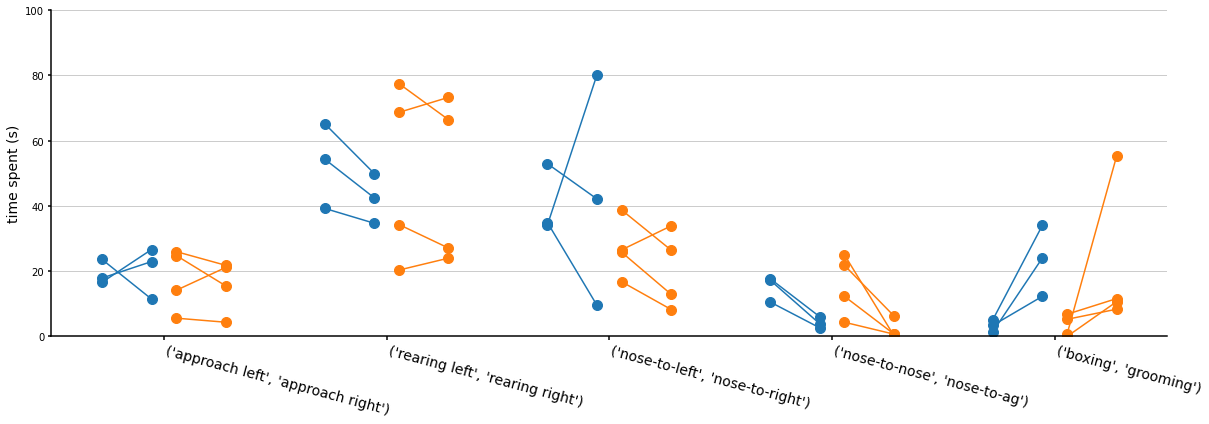

In [173]:
#phase_dict = {'habituate':(500,5500), 'preference':(6500,6500+11500), 'novelty':(18500,18500+11500)}
phase_dict = {'preference':(6500,6500+11500)}
behaviors = ( ('approach left', 'approach right'), ('rearing left', 'rearing right'), ('nose-to-left', 'nose-to-right'),
            ('nose-to-nose', 'nose-to-ag'), ('boxing', 'grooming')
            )
plot_jog = .5
phase_jog = plot_jog * 1.5
cond_jog = phase_jog * len(phase_dict)
beh_jog = cond_jog * 3

x_ticks = []

f,ax = plt.subplots(1,1,figsize=(20,6))

for beh_i, the_behaviors in enumerate(behaviors):
    #print(the_behaviors)
    for cond_i, the_cond in enumerate(stat_dict.keys()):
        #print(the_cond)
        for phase_i, the_phase in enumerate(phase_dict.keys()):
            x1 = (cond_i * cond_jog) + (phase_i * phase_jog) + (beh_i * beh_jog)
            #print(x1, x1+plot_jog)
            for the_subj in stat_dict[the_cond].keys():
                df_labels = stat_dict[the_cond][the_subj]['labels']
                ax.plot( (x1, x1 + plot_jog), 
                        (sum(df_labels.label.loc[df_labels.frame.isin(np.arange(phase_dict[the_phase][0],phase_dict[the_phase][1]))].values == the_behaviors[0])/20, 
                         sum(df_labels.label.loc[df_labels.frame.isin(np.arange(phase_dict[the_phase][0],phase_dict[the_phase][1]))].values == the_behaviors[1])/20), 
                         'o-', color = cdict[the_cond], markersize=10, alpha=1)
            #x_ticks.append( (x1, x1 + plot_jog) )
    
    x_ticks.append((cond_i * cond_jog) + (phase_i * phase_jog) + (beh_i * beh_jog) - (plot_jog/4) )


twoaxis(ax)
ax.set_xticks(np.asarray(x_ticks).flatten())
ax.set_xticklabels(behaviors, fontsize=14, rotation=345, horizontalalignment='left' )
ax.set_ylabel('time spent (s)', fontsize=14)
ax.set_ylim(0,100)
ax.grid(color='gray', alpha=.5, axis='y')
plt.show()


***
### auROC ID of tuned populations

### sandbox:

In [480]:
the_cond = 'FMR1KO'
the_subj = 'OM038'
event_types = ['nose-to-left', 'nose-to-nose', 'nose-to-ag']

In [481]:
df_labels = stat_dict[the_cond][the_subj]['labels']
align_pnts = df_labels.frame.loc[df_labels.label.isin(event_types)].values
trace_mtx = stat_dict[the_cond][the_subj]['trace_mtx']

In [482]:
# convert alignment points to raster:
align_raster = np.zeros((trace_mtx.shape[0],))
align_raster[align_pnts] = 1
print(sum(align_raster))

1337.0


In [483]:
# find cells with significant auROC based on time-shuffled distribution:
frames = (6200,6200+11500)
n_iter = 500

auroc = []
auroc_p = []

for cellnum,the_trace in enumerate(trace_mtx[frames[0]:frames[1],:].transpose()):
    the_auroc = metrics.roc_auc_score(align_raster[frames[0]:frames[1]], the_trace)
    auroc.append(the_auroc)
    shift_auroc = []
    for the_iter in range(n_iter):
        shift_trace = np.roll(the_trace, np.random.choice(np.arange(len(the_trace))))
        shift_auroc.append(metrics.roc_auc_score(align_raster[frames[0]:frames[1]], shift_trace) )
    auroc_p.append(prob_from_dist(the_auroc, shift_auroc, hist_range = (-1,1), tails = 2))


In [484]:
mod_cells = np.argwhere(np.asarray(auroc_p) <= .01).flatten()
pos_mod_cells = np.intersect1d(mod_cells, np.argwhere(np.asarray(auroc) >= .6).flatten())
neg_mod_cells = np.intersect1d(mod_cells, np.argwhere(np.asarray(auroc) <= .4).flatten())
print(pos_mod_cells)
print(len(pos_mod_cells) / len(auroc))
print(neg_mod_cells)
print(len(neg_mod_cells) / len(auroc))

[ 16  17  18  23  24  26  33  49  50  53  57  74  87  88  91  97 100 105
 113 134 157 162]
0.1301775147928994
[  2  10  28  37  38  45  54  56  73  79 117 137 147 159]
0.08284023668639054


137


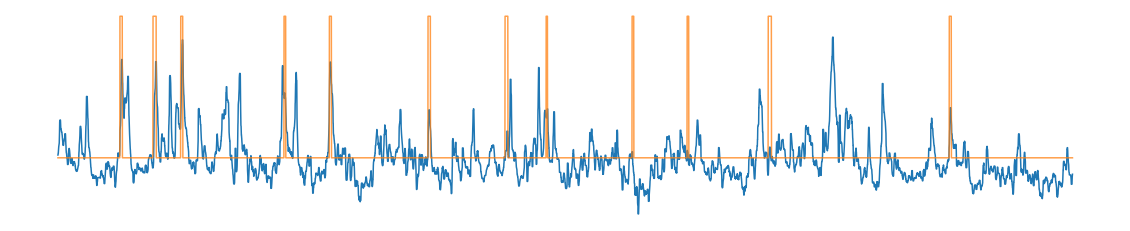

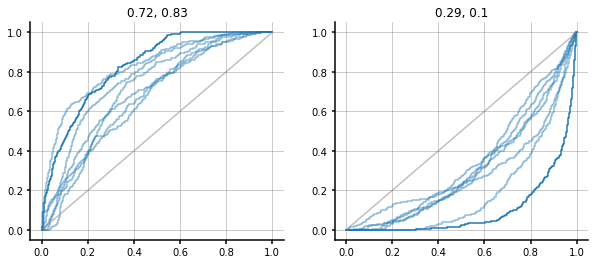

In [478]:
cellnum = np.argmax(auroc)
print(cellnum)

f,ax = plt.subplots(1,1,figsize=(20,4))
ax.plot(signal.medfilt(trace_mtx[phase_dict['preference'][0]:phase_dict['preference'][1],cellnum], 15))
#ax.plot(np.mean(trace_mtx[phase_dict['preference'][0]:phase_dict['preference'][1],negpos_mod_cellsd_cells], axis=1))
ax.plot(align_raster[phase_dict['preference'][0]:phase_dict['preference'][1]]*max(trace_mtx[phase_dict['preference'][0]:phase_dict['preference'][1],cellnum]), alpha=.75)

ax.axis('off')
plt.show()

f,ax = plt.subplots(1,2,figsize=(10,4))

title_str = ''
for cellnum in pos_mod_cells:
    fpr, tpr, roc_thresh = metrics.roc_curve(align_raster[frames[0]:frames[1]], trace_mtx[frames[0]:frames[1], cellnum])
    auc = metrics.roc_auc_score(align_raster[frames[0]:frames[1]], trace_mtx[frames[0]:frames[1], cellnum])
    ax[0].plot(fpr,tpr, color=cmap(0), alpha=.5)
    
title_str += str(round(np.mean([auroc[i] for i in pos_mod_cells]),2))
fpr, tpr, roc_thresh = metrics.roc_curve(align_raster[frames[0]:frames[1]], np.mean(trace_mtx[frames[0]:frames[1], pos_mod_cells], axis=1))
auc = metrics.roc_auc_score(align_raster[frames[0]:frames[1]], np.mean(trace_mtx[frames[0]:frames[1], pos_mod_cells], axis=1))
ax[0].plot(fpr,tpr, color=cmap(0), alpha=1, linewidth=1.5)
title_str += ', '+str(round(auc,2))
ax[0].set_title(title_str)

title_str = ''
for cellnum in neg_mod_cells:
    fpr, tpr, roc_thresh = metrics.roc_curve(align_raster[frames[0]:frames[1]], trace_mtx[frames[0]:frames[1], cellnum])
    auc = metrics.roc_auc_score(align_raster[frames[0]:frames[1]], trace_mtx[frames[0]:frames[1], cellnum])
    ax[1].plot(fpr,tpr, color=cmap(0), alpha=.5)

title_str += str(round(np.mean([auroc[i] for i in neg_mod_cells]),2))
fpr, tpr, roc_thresh = metrics.roc_curve(align_raster[frames[0]:frames[1]], np.mean(trace_mtx[frames[0]:frames[1], neg_mod_cells], axis=1))
auc = metrics.roc_auc_score(align_raster[frames[0]:frames[1]], np.mean(trace_mtx[frames[0]:frames[1], neg_mod_cells], axis=1))
ax[1].plot(fpr,tpr, color=cmap(0), alpha=1, linewidth=1.5)
title_str += ', '+str(round(auc,2))
ax[1].set_title(title_str)

for a in ax:
    twoaxis(a)
    a.grid('on', color='gray', alpha=.5)
    a.plot([0,1], [0,1], color='gray', alpha=.5)
plt.show()

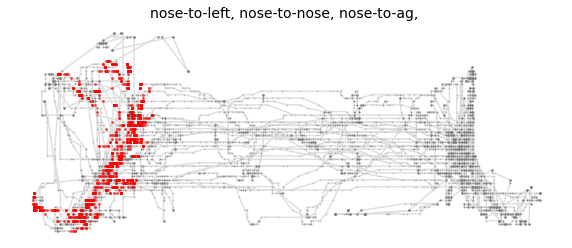

In [487]:
# plot spatial map of events:
f,ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(stat_dict[the_cond][the_subj]['COM'][6000:18000,1], stat_dict[the_cond][the_subj]['COM'][6000:18000,0], 'o-', markersize=1, alpha=.25, color='gray')
ax.plot(stat_dict[the_cond][the_subj]['COM'][align_pnts,1], stat_dict[the_cond][the_subj]['COM'][align_pnts,0], 'o', markersize=2, alpha=.5, color='red')

ax.set_title(''.join([i + ', ' for i in event_types]), fontsize=14)
ax.axis('off')
plt.show()


***
### pooling loop

In [493]:
print(align_pnts)

[ 6450  6451  6452 ... 17883 17884 17885]


In [504]:
sides = (95, 230)
event_types = ['nose-to-right', ('nose-to-ag', 'nose-to-nose') ] 
align_pad = 200
phase_dict = {'preference': (6500, 6500+11500)}
n_iter = 5


for the_cond in stat_dict.keys(): # each genotype
    print('\n',the_cond)
    if 'linear' in sorted(stat_dict[the_cond].keys())[0]:
        print('** Repeated measures detected **')
        for the_exp in stat_dict[the_cond].keys(): # each experiment condition
            print(the_exp)
            
            # This needs to be populated with per-experiment version of the following:
            
                        
    else: # same as above loop but without repeated measures for each subject:
        print('** No repeated measures detected **')
        for the_subj in stat_dict[the_cond]: # each subject
                print('\t',the_subj)
                for the_phase in sorted(phase_dict.keys()):
                    frames = (phase_dict[the_phase][0], phase_dict[the_phase][1])
                    for event_type in event_types:
                        if isinstance(event_type, str):
                            event_type = [event_type]
                        print('\t', event_type)
                        # load traces and labels, extract samples in the phase of interest
                        trace_mtx = stat_dict[the_cond][the_subj]['trace_mtx'][frames[0]:frames[1], :]
                        df_labels = stat_dict[the_cond][the_subj]['labels']
                        align_pnts = df_labels.frame.loc[df_labels.label.isin(event_type)].values - frames[0]
                        #print('\talign points: {}'.format(align_pnts[the_side][event_type]))

                        # convert alignment points to raster:
                        align_raster = np.zeros((trace_mtx.shape[0],))
                        padded_align_pnts = align_pnts
                        #padded_align_pnts = np.asarray(
                        #    [np.arange(i, i+align_pad) for i in align_pnts[the_side][event_type] if (i+align_pad) < trace_mtx.shape[0]]
                        #).flatten()

                        if len(align_pnts):
                            align_raster[padded_align_pnts] = 1

                            print('\t', trace_mtx.shape, align_raster.shape, min(np.argwhere(align_raster==1)), max(np.argwhere(align_raster==1)))

                            # find cells with significant auROC based on time-shuffled distribution:
                            auroc = []
                            auroc_p = []

                            for cellnum,the_trace in enumerate(trace_mtx.transpose()):
                                the_auroc = metrics.roc_auc_score(align_raster, the_trace)
                                #the_auroc = metrics.average_precision_score(align_raster[frames[0]:frames[1]], the_trace)
                                auroc.append(the_auroc)
                                shift_auroc = []
                                for the_iter in range(n_iter): # time-shuffle traces for null distribution:
                                    shift_trace = np.roll(the_trace, np.random.choice(np.arange(len(the_trace))))
                                    shift_auroc.append(metrics.roc_auc_score(align_raster, shift_trace) )

                                    # precision-recall curve instead of ROC:
                                    #shift_auroc.append(metrics.average_precision_score(align_raster[frames[0]:frames[1]], shift_trace) )

                                auroc_p.append(prob_from_dist(the_auroc, shift_auroc, hist_range = (0,1), tails = 2))
                        else:
                            print('\t** no events found')
                            auroc = []
                            auroc_p = []
                        statstr = 'auroc_' + ''.join([i + ', ' for i in event_type])
                        stat_dict[the_cond][the_subj][statstr] = auroc
                        statstr = 'auroc_p_' + ''.join([i + ', ' for i in event_type])
                        stat_dict[the_cond][the_subj][statstr] = auroc_p
                        print('\n')
                        



 FMR1CTRL
** No repeated measures detected **
	 OM047
	 ['nose-to-right']
	 (11500, 75) (11500,) [14] [11478]


	 ('nose-to-ag', 'nose-to-nose')
	 (11500, 75) (11500,) [459] [10880]


	 OM051
	 ['nose-to-right']
	 (11500, 109) (11500,) [0] [11499]


	 ('nose-to-ag', 'nose-to-nose')
	 (11500, 109) (11500,) [1076] [10431]


	 OM035
	 ['nose-to-right']
	 (11500, 77) (11500,) [367] [10340]


	 ('nose-to-ag', 'nose-to-nose')
	 (11500, 77) (11500,) [939] [8702]



 FMR1KO
** No repeated measures detected **
	 OM045
	 ['nose-to-right']
	 (11500, 44) (11500,) [1126] [11457]


	 ('nose-to-ag', 'nose-to-nose')
	 (11500, 44) (11500,) [594] [9858]


	 OM038
	 ['nose-to-right']
	 (11500, 169) (11500,) [76] [11492]


	 ('nose-to-ag', 'nose-to-nose')
	 (11500, 169) (11500,) [376] [11319]


	 OM042
	 ['nose-to-right']
	 (11500, 62) (11500,) [3200] [5968]


	 ('nose-to-ag', 'nose-to-nose')
	 (11500, 62) (11500,) [0] [11499]


	 OM040
	 ['nose-to-right']
	 (11500, 176) (11500,) [391] [10528]


	 ('nose

In [530]:
stat_dict = pickle.load(open('stat_dict.pkl' , 'rb'))

In [531]:
for i in stat_dict.keys():
    print(i)
    for j in stat_dict[i].keys():
        print('\t',j)
        for k in stat_dict[i][j].keys():
            print('\t\t',k)

FMR1CTRL
	 OM047
		 trace_mtx
		 raster_mtx
		 COM
		 labels
		 auroc_nose-to-right
		 auroc_p_nose-to-right
		 auroc_nose-to-left
		 auroc_p_nose-to-left
		 auroc_nose-to-ag, nose-to-nose
		 auroc_p_nose-to-ag, nose-to-nose
		 auroc_nose-to-nose
		 auroc_p_nose-to-nose
	 OM051
		 trace_mtx
		 raster_mtx
		 COM
		 labels
		 auroc_nose-to-right
		 auroc_p_nose-to-right
		 auroc_nose-to-left
		 auroc_p_nose-to-left
		 auroc_nose-to-ag, nose-to-nose
		 auroc_p_nose-to-ag, nose-to-nose
		 auroc_nose-to-nose
		 auroc_p_nose-to-nose
	 OM035
		 trace_mtx
		 raster_mtx
		 COM
		 labels
		 auroc_nose-to-right
		 auroc_p_nose-to-right
		 auroc_nose-to-left
		 auroc_p_nose-to-left
		 auroc_nose-to-ag, nose-to-nose
		 auroc_p_nose-to-ag, nose-to-nose
		 auroc_nose-to-nose
		 auroc_p_nose-to-nose
FMR1KO
	 OM045
		 trace_mtx
		 raster_mtx
		 COM
		 labels
		 auroc_nose-to-right
		 auroc_p_nose-to-right
		 auroc_nose-to-left
		 auroc_p_nose-to-left
		 auroc_nose-to-ag, nose-to-nose
		 auroc_p_nose-to

In [2665]:
fn = 'frame_aligned_data_baclofen_rocAllCotune.pkl'
with open(fn, 'wb') as fp:
    pickle.dump(stat_dict,fp)

***


In [61]:
df = stat_dict['FMR1KO']['OM040']['labels']

In [62]:
df.label.unique()

array(['0.0', 'approach left', 'nose-to-left', 'nose-to-nose',
       'rearing left', 'approach right', 'nose-to-other', 'nose-to-right',
       'rearing right', 'grooming', 'boxing', 'nose-to-ag'], dtype=object)

***
## no repeated measures pooling / plotting loop 

In [24]:
stat_dict = pickle.load(open('frame_aligned_data_20200415_annotated_2.pkl' , 'rb'))

In [25]:
for i in stat_dict.keys():
    print(i)
    for j in stat_dict[i].keys():
        print('\t',j)
        for k in stat_dict[i][j].keys():
            print('\t\t',k)

FMR1CTRL
	 OM047
		 trace_mtx
		 raster_mtx
		 COM
		 labels
		 auroc_nose-to-right
		 auroc_p_nose-to-right
		 auroc_nose-to-left
		 auroc_p_nose-to-left
		 auroc_nose-to-nose
		 auroc_p_nose-to-nose
		 auroc_nose-to-ag
		 auroc_p_nose-to-ag
		 auroc_boxing
		 auroc_p_boxing
		 auroc_approach left
		 auroc_p_approach left
		 auroc_approach right
		 auroc_p_approach right
		 auroc_nose-to-left, nose-to-nose, nose-to-ag
		 auroc_p_nose-to-left, nose-to-nose, nose-to-ag
		 auroc_rearing left
		 auroc_p_rearing left
		 auroc_rearing right
		 auroc_p_rearing right
		 auroc_rearing left, rearing right
		 auroc_p_rearing left, rearing right
		 auroc_grooming
		 auroc_p_grooming
	 OM051
		 trace_mtx
		 raster_mtx
		 COM
		 labels
		 auroc_nose-to-right
		 auroc_p_nose-to-right
		 auroc_nose-to-left
		 auroc_p_nose-to-left
		 auroc_nose-to-nose
		 auroc_p_nose-to-nose
		 auroc_nose-to-ag
		 auroc_p_nose-to-ag
		 auroc_boxing
		 auroc_p_boxing
		 auroc_approach left
		 auroc_p_approach left
		 

In [181]:
event_types = ['rearing left', 'rearing right', 'grooming']
print(event_types), 
print([''.join([j for j in i]) + '_pos_mod' for i in event_types] + [''.join([j for j in i]) + '_neg_mod' for i in event_types])

['rearing left', 'rearing right', 'grooming']
['rearing left_pos_mod', 'rearing right_pos_mod', 'grooming_pos_mod', 'rearing left_neg_mod', 'rearing right_neg_mod', 'grooming_neg_mod']


In [178]:
event_types

['rearing left', 'rearing right']

In [182]:
event_types = event_types
p_thresh = 0.01
roc_thresh = .6
align_pad = 200
frames = (6200,6200+11500)
#frames = (10,5500)

frac_dict = dict.fromkeys(stat_dict)

for the_cond in stat_dict.keys(): # each genotype
    print('\n',the_cond)

    frac_dict[the_cond] = dict.fromkeys([''.join([j for j in i]) + '_pos_mod' for i in event_types] + 
                                        [''.join([j for j in i]) + '_neg_mod' for i in event_types])
    
    for i in frac_dict[the_cond]:
        frac_dict[the_cond][i] = []
    print(frac_dict[the_cond].keys())

    for the_subj in sorted(stat_dict[the_cond]): # each subject
        print('\t',the_subj)

        trace_mtx = stat_dict[the_cond][the_subj]['trace_mtx']
        df_labels = stat_dict[the_cond][the_subj]['labels']
        
        for event_type in event_types:

            # create raster from event points:
            align_raster = np.zeros((trace_mtx.shape[0],))
            if isinstance(event_type, str):
                align_pnts = df_labels.frame.loc[df_labels.label.isin([event_type])].values
            else:
                align_pnts = df_labels.frame.loc[df_labels.label.isin(event_type)].values
            padded_align_pnts = align_pnts
            align_raster[padded_align_pnts] = 1
            
            if isinstance(event_type, tuple):
                event_type = ''.join([i + ', ' for i in event_type])[:-2]
            print('\t',event_type)
            #print('\talign points: {}'.format(align_pnts[the_side][event_type]))

            # load auROC and auROC_p vectors:
            stat_str = 'auroc_p_' + event_type
            the_auroc_p = stat_dict[the_cond][the_subj][stat_str]
            
            stat_str = 'auroc_' + event_type
            the_auroc = stat_dict[the_cond][the_subj][stat_str]
            
            pos_mod = np.intersect1d(np.argwhere(np.asarray(the_auroc_p) <= p_thresh).flatten(), np.argwhere(np.asarray(the_auroc) >= roc_thresh).flatten())
            neg_mod = np.intersect1d(np.argwhere(np.asarray(the_auroc_p) <= p_thresh).flatten(), np.argwhere(np.asarray(the_auroc) <= (1-roc_thresh)).flatten())

            # positively modulated cells:
            stat_str = ''.join([j for j in event_type]) + '_pos_mod'
            stat_str = stat_str.replace(', ','')
            if len(pos_mod) and sum(align_raster[frames[0]:frames[1]]): # check for modulated cells and zone entries
                avg_trace = np.mean(trace_mtx[:,pos_mod], axis=1)
                auc = metrics.roc_auc_score(align_raster[frames[0]:frames[1]], avg_trace[frames[0]:frames[1]])
                #frac_dict[the_cond][the_exp]['positive_mod_left'].append(auc)
                frac_dict[the_cond][stat_str].append(len(pos_mod)/len(the_auroc))
                if len(pos_mod==1):
                    pos_mod= pos_mod[0]
                #frac_dict[the_cond][the_exp]['positive_mod_left'].append(np.mean(the_auroc[pos_mod_l]))
            else:
                #frac_dict[the_cond][the_exp]['positive_mod_left'].append(np.nan)
                frac_dict[the_cond][stat_str].append(0)
                
            # negatively modulated cells:
            stat_str = ''.join([j for j in event_type]) + '_neg_mod'
            stat_str = stat_str.replace(', ','')
            if len(neg_mod) and sum(align_raster[frames[0]:frames[1]]): # check for modulated cells and zone entries
                avg_trace = np.mean(trace_mtx[:, neg_mod], axis=1)
                auc = metrics.roc_auc_score(align_raster[frames[0]:frames[1]], avg_trace[frames[0]:frames[1]])
                #frac_dict[the_cond][the_exp]['positive_mod_left'].append(auc)
                frac_dict[the_cond][stat_str].append(len(neg_mod)/len(the_auroc))
                if len(neg_mod==1):
                    neg_mod = neg_mod[0]
                #frac_dict[the_cond][the_exp]['positive_mod_left'].append(np.mean(the_auroc[pos_mod_l]))
            else:
                #frac_dict[the_cond][the_exp]['positive_mod_left'].append(np.nan)
                frac_dict[the_cond][stat_str].append(0)
        
            


 FMR1CTRL
dict_keys(['rearing left_pos_mod', 'rearing right_pos_mod', 'grooming_pos_mod', 'rearing left_neg_mod', 'rearing right_neg_mod', 'grooming_neg_mod'])
	 OM035
	 rearing left
	 rearing right
	 grooming
	 OM047
	 rearing left
	 rearing right
	 grooming
	 OM051
	 rearing left
	 rearing right
	 grooming

 FMR1KO
dict_keys(['rearing left_pos_mod', 'rearing right_pos_mod', 'grooming_pos_mod', 'rearing left_neg_mod', 'rearing right_neg_mod', 'grooming_neg_mod'])
	 OM038
	 rearing left
	 rearing right
	 grooming
	 OM040
	 rearing left
	 rearing right
	 grooming
	 OM042
	 rearing left
	 rearing right
	 grooming
	 OM045
	 rearing left
	 rearing right
	 grooming


In [29]:
print(frac_dict.keys())
print(frac_dict['FMR1KO'].keys())


dict_keys(['FMR1CTRL', 'FMR1KO'])
dict_keys(['nose-to-nose_pos_mod', 'nose-to-ag_pos_mod', 'boxing_pos_mod', 'nose-to-right_pos_mod', 'nose-to-nose_neg_mod', 'nose-to-ag_neg_mod', 'boxing_neg_mod', 'nose-to-right_neg_mod'])


### pie charts

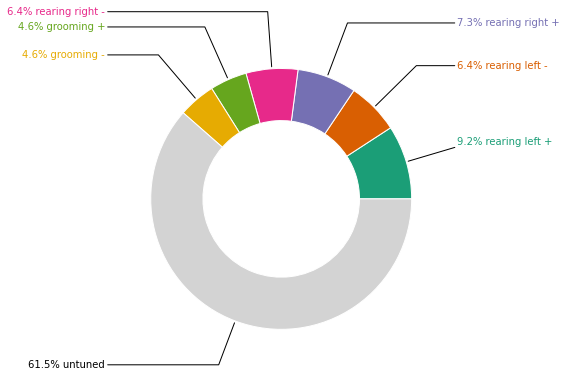

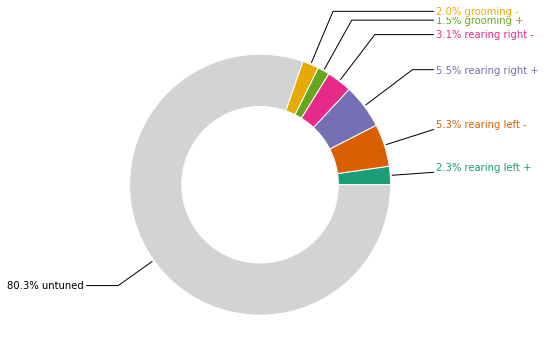

In [183]:
pie_cmap = plt.get_cmap('Dark2')

stats_to_do = ['rearing left_pos_mod', 'rearing left_neg_mod', 
               'rearing right_pos_mod', 'rearing right_neg_mod',
               'grooming_pos_mod', 'grooming_neg_mod'
              ]

stat_labels = ['rearing left +', 'rearing left -', 
               'rearing right +', 'rearing right -',
               'grooming +', 'grooming -',
               'untuned']

f,ax = plt.subplots(1, 1, figsize = (6,6))

pie_vals = [np.nanmedian(frac_dict['FMR1CTRL'][i]) for i in stats_to_do] + [1-np.sum([np.nanmedian(frac_dict['FMR1CTRL'][i]) for i in stats_to_do])]
#print(pie_vals)
pie_col = [pie_cmap(i) for i in range(len(pie_vals))]
pie_col[-1] = 'lightgray'
text_col = pie_col.copy()
text_col[-1] = 'black'

wedges,texts = ax.pie(pie_vals, radius = 1,colors = pie_col, wedgeprops = dict(width=.4, edgecolor='w'))
# pie labels:
bbox_props = dict(boxstyle="square,pad=0.01",fc="w", ec="w", lw=1)
kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="bottom")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle}, color='black')
    ax.annotate(str(round(pie_vals[i]*100,1)) + '% '+stat_labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw, color=text_col[i])

#f.tight_layout()
plt.show()

f,ax = plt.subplots(1, 1, figsize = (6,6))

pie_vals = [np.nanmedian(frac_dict['FMR1KO'][i]) for i in stats_to_do] + [1-np.sum([np.nanmedian(frac_dict['FMR1KO'][i]) for i in stats_to_do])]
#print(pie_vals)

pie_col = [pie_cmap(i) for i in range(len(pie_vals))]
pie_col[-1] = 'lightgray'
text_col = pie_col.copy()
text_col[-1] = 'black'
wedges,texts = ax.pie(pie_vals, radius = 1,colors = pie_col, wedgeprops = dict(width=.4, edgecolor='w'))
# pie labels:
bbox_props = dict(boxstyle="square,pad=0.01",fc="w", ec="w", lw=1)
kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="bottom")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle}, color='black')
    ax.annotate(str(round(pie_vals[i]*100,1)) + '% '+stat_labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw, color=text_col[i])


plt.show()

***
### Pooled Modulation Index (mean auROC, ensemble auROC) 

In [24]:
stat_dict = pickle.load(open('frame_aligned_data_20200415_annotated.pkl' , 'rb'))

In [63]:
for i in stat_dict.keys():
    print(i)
    for j in stat_dict[i].keys():
        print('\t',j)
        for k in stat_dict[i][j].keys():
            print('\t\t',k)

FMR1CTRL
	 OM047
		 trace_mtx
		 raster_mtx
		 COM
		 labels
		 auroc_nose-to-right
		 auroc_p_nose-to-right
		 auroc_nose-to-left
		 auroc_p_nose-to-left
		 auroc_nose-to-nose
		 auroc_p_nose-to-nose
		 auroc_nose-to-ag
		 auroc_p_nose-to-ag
		 auroc_boxing
		 auroc_p_boxing
		 auroc_approach left
		 auroc_p_approach left
		 auroc_approach right
		 auroc_p_approach right
		 auroc_nose-to-left, nose-to-nose, nose-to-ag
		 auroc_p_nose-to-left, nose-to-nose, nose-to-ag
	 OM051
		 trace_mtx
		 raster_mtx
		 COM
		 labels
		 auroc_nose-to-right
		 auroc_p_nose-to-right
		 auroc_nose-to-left
		 auroc_p_nose-to-left
		 auroc_nose-to-nose
		 auroc_p_nose-to-nose
		 auroc_nose-to-ag
		 auroc_p_nose-to-ag
		 auroc_boxing
		 auroc_p_boxing
		 auroc_approach left
		 auroc_p_approach left
		 auroc_approach right
		 auroc_p_approach right
		 auroc_nose-to-left, nose-to-nose, nose-to-ag
		 auroc_p_nose-to-left, nose-to-nose, nose-to-ag
	 OM035
		 trace_mtx
		 raster_mtx
		 COM
		 labels
		 auroc_no

In [121]:
event_types = ['nose-to-nose', 'nose-to-ag', 'boxing', 'nose-to-right', 'nose-to-left', 
               'approach left', 'approach right', 'boxing', ('nose-to-left', 'nose-to-nose', 'nose-to-ag')]
print(event_types)
print([''.join([j for j in i]) + '_pos_mod' for i in event_types] + [''.join([j for j in i]) + '_neg_mod' for i in event_types])

['nose-to-nose', 'nose-to-ag', 'boxing', 'nose-to-right', 'nose-to-left', 'approach left', 'approach right', 'boxing', ('nose-to-left', 'nose-to-nose', 'nose-to-ag')]
['nose-to-nose_pos_mod', 'nose-to-ag_pos_mod', 'boxing_pos_mod', 'nose-to-right_pos_mod', 'nose-to-left_pos_mod', 'approach left_pos_mod', 'approach right_pos_mod', 'boxing_pos_mod', 'nose-to-leftnose-to-nosenose-to-ag_pos_mod', 'nose-to-nose_neg_mod', 'nose-to-ag_neg_mod', 'boxing_neg_mod', 'nose-to-right_neg_mod', 'nose-to-left_neg_mod', 'approach left_neg_mod', 'approach right_neg_mod', 'boxing_neg_mod', 'nose-to-leftnose-to-nosenose-to-ag_neg_mod']


In [122]:
event_types

['nose-to-nose',
 'nose-to-ag',
 'boxing',
 'nose-to-right',
 'nose-to-left',
 'approach left',
 'approach right',
 'boxing',
 ('nose-to-left', 'nose-to-nose', 'nose-to-ag')]

In [156]:
event_types = event_types
p_thresh = 0.01
roc_thresh = .6
align_pad = 200
frames = (6200,6200+11500)
#frames = (10,5500)

frac_dict = dict.fromkeys(stat_dict)

for the_cond in stat_dict.keys(): # each genotype
    print('\n',the_cond)

    frac_dict[the_cond] = dict.fromkeys([''.join([j for j in i]) + '_pos_mod' for i in event_types] + 
                                        [''.join([j for j in i]) + '_neg_mod' for i in event_types])
    
    for i in frac_dict[the_cond]:
        frac_dict[the_cond][i] = []
    print(frac_dict[the_cond].keys())

    for the_subj in sorted(stat_dict[the_cond]): # each subject
        print('\t',the_subj)

        trace_mtx = stat_dict[the_cond][the_subj]['trace_mtx']
        df_labels = stat_dict[the_cond][the_subj]['labels']
        
        for event_type in event_types:

            # create raster from event points:
            align_raster = np.zeros((trace_mtx.shape[0],))
            if isinstance(event_type, str):
                align_pnts = df_labels.frame.loc[df_labels.label.isin([event_type])].values
            else:
                align_pnts = df_labels.frame.loc[df_labels.label.isin(event_type)].values
            padded_align_pnts = align_pnts
            align_raster[padded_align_pnts] = 1
            
            if isinstance(event_type, tuple):
                event_type = ''.join([i + ', ' for i in event_type])[:-2]
            print('\t',event_type)
            #print('\talign points: {}'.format(align_pnts[the_side][event_type]))

            # load auROC and auROC_p vectors:
            stat_str = 'auroc_p_' + event_type
            the_auroc_p = stat_dict[the_cond][the_subj][stat_str]
            
            stat_str = 'auroc_' + event_type
            the_auroc = stat_dict[the_cond][the_subj][stat_str]
            
            pos_mod = np.intersect1d(np.argwhere(np.asarray(the_auroc_p) <= p_thresh).flatten(), np.argwhere(np.asarray(the_auroc) >= roc_thresh).flatten())
            neg_mod = np.intersect1d(np.argwhere(np.asarray(the_auroc_p) <= p_thresh).flatten(), np.argwhere(np.asarray(the_auroc) <= (1-roc_thresh)).flatten())

            # positively modulated cells:
            stat_str = ''.join([j for j in event_type]) + '_pos_mod'
            stat_str = stat_str.replace(', ','')
            if len(pos_mod) and sum(align_raster[frames[0]:frames[1]]): # check for modulated cells and zone entries
                avg_trace = np.mean(trace_mtx[:,pos_mod], axis=1)
                auc = metrics.roc_auc_score(align_raster[frames[0]:frames[1]], avg_trace[frames[0]:frames[1]])
                frac_dict[the_cond][stat_str].append(auc)
                #frac_dict[the_cond][stat_str].append(len(pos_mod)/len(the_auroc))
                #frac_dict[the_cond][stat_str].append(np.mean([the_auroc[i] for i in pos_mod]))
                if len(pos_mod==1):
                    pos_mod= pos_mod[0]
                #frac_dict[the_cond][the_exp]['positive_mod_left'].append(np.mean(the_auroc[pos_mod_l]))
            else:
                frac_dict[the_cond][stat_str].append(np.nan)
                #frac_dict[the_cond][stat_str].append(0)
                
            # negatively modulated cells:
            stat_str = ''.join([j for j in event_type]) + '_neg_mod'
            stat_str = stat_str.replace(', ','')
            if len(neg_mod) and sum(align_raster[frames[0]:frames[1]]): # check for modulated cells and zone entries
                avg_trace = np.mean(trace_mtx[:, neg_mod], axis=1)
                auc = metrics.roc_auc_score(align_raster[frames[0]:frames[1]], avg_trace[frames[0]:frames[1]])
                frac_dict[the_cond][stat_str].append(auc)
                #frac_dict[the_cond][stat_str].append(np.mean([the_auroc[i] for i in neg_mod]))
                if len(neg_mod==1):
                    neg_mod = neg_mod[0]
                #frac_dict[the_cond][the_exp]['positive_mod_left'].append(np.mean(the_auroc[pos_mod_l]))
            else:
                frac_dict[the_cond][stat_str].append(np.nan)
                #frac_dict[the_cond][stat_str].append(0)
        
            


 FMR1CTRL
dict_keys(['nose-to-nose_pos_mod', 'nose-to-ag_pos_mod', 'boxing_pos_mod', 'nose-to-right_pos_mod', 'nose-to-left_pos_mod', 'approach left_pos_mod', 'approach right_pos_mod', 'nose-to-leftnose-to-nosenose-to-ag_pos_mod', 'nose-to-nose_neg_mod', 'nose-to-ag_neg_mod', 'boxing_neg_mod', 'nose-to-right_neg_mod', 'nose-to-left_neg_mod', 'approach left_neg_mod', 'approach right_neg_mod', 'nose-to-leftnose-to-nosenose-to-ag_neg_mod'])
	 OM035
	 nose-to-nose
	 nose-to-ag
	 boxing
	 nose-to-right
	 nose-to-left
	 approach left
	 approach right
	 boxing
	 nose-to-left, nose-to-nose, nose-to-ag
	 OM047
	 nose-to-nose
	 nose-to-ag
	 boxing
	 nose-to-right
	 nose-to-left
	 approach left
	 approach right
	 boxing
	 nose-to-left, nose-to-nose, nose-to-ag
	 OM051
	 nose-to-nose
	 nose-to-ag
	 boxing
	 nose-to-right
	 nose-to-left
	 approach left
	 approach right
	 boxing
	 nose-to-left, nose-to-nose, nose-to-ag

 FMR1KO
dict_keys(['nose-to-nose_pos_mod', 'nose-to-ag_pos_mod', 'boxing_pos_mo

In [157]:
for a in frac_dict.keys():
    print(a)
    for b in frac_dict[a].keys():
        print('\t',b)

FMR1CTRL
	 nose-to-nose_pos_mod
	 nose-to-ag_pos_mod
	 boxing_pos_mod
	 nose-to-right_pos_mod
	 nose-to-left_pos_mod
	 approach left_pos_mod
	 approach right_pos_mod
	 nose-to-leftnose-to-nosenose-to-ag_pos_mod
	 nose-to-nose_neg_mod
	 nose-to-ag_neg_mod
	 boxing_neg_mod
	 nose-to-right_neg_mod
	 nose-to-left_neg_mod
	 approach left_neg_mod
	 approach right_neg_mod
	 nose-to-leftnose-to-nosenose-to-ag_neg_mod
FMR1KO
	 nose-to-nose_pos_mod
	 nose-to-ag_pos_mod
	 boxing_pos_mod
	 nose-to-right_pos_mod
	 nose-to-left_pos_mod
	 approach left_pos_mod
	 approach right_pos_mod
	 nose-to-leftnose-to-nosenose-to-ag_pos_mod
	 nose-to-nose_neg_mod
	 nose-to-ag_neg_mod
	 boxing_neg_mod
	 nose-to-right_neg_mod
	 nose-to-left_neg_mod
	 approach left_neg_mod
	 approach right_neg_mod
	 nose-to-leftnose-to-nosenose-to-ag_neg_mod


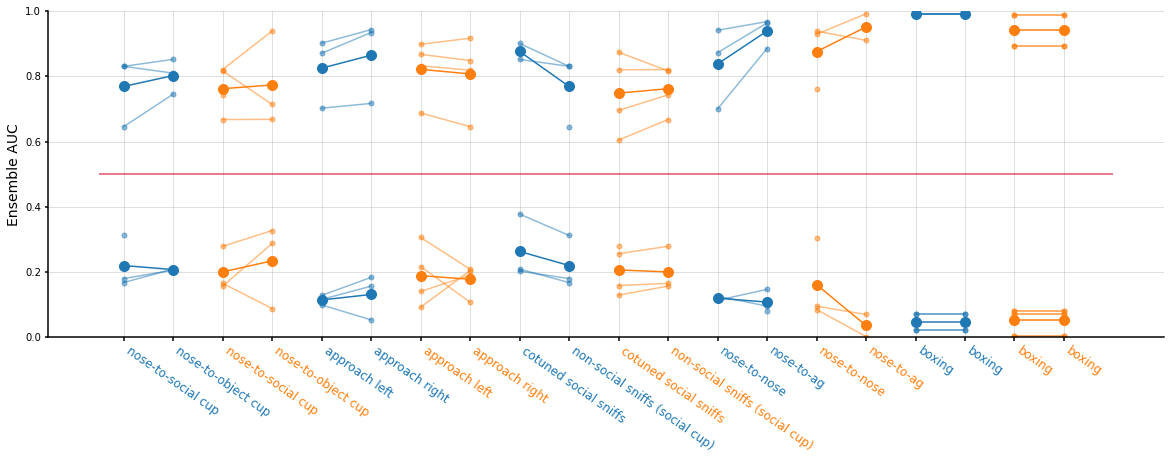

In [159]:
# pooled ROC:

pos_stats = [('nose-to-left_pos_mod', 'nose-to-right_pos_mod'), 
             ('approach left_pos_mod', 'approach right_pos_mod'),
             ('nose-to-leftnose-to-nosenose-to-ag_pos_mod', 'nose-to-left_pos_mod'),
             ('nose-to-nose_pos_mod', 'nose-to-ag_pos_mod'),
             ('boxing_pos_mod', 'boxing_pos_mod')
            ]

neg_stats = [('nose-to-left_neg_mod', 'nose-to-right_neg_mod'), 
             ('approach left_neg_mod', 'approach right_neg_mod'),
             ('nose-to-leftnose-to-nosenose-to-ag_neg_mod', 'nose-to-left_neg_mod'),
             ('nose-to-nose_neg_mod', 'nose-to-ag_neg_mod'),
             ('boxing_neg_mod', 'boxing_neg_mod')
            ]

expjog = .5
condjog = 1
cdict = dict(zip(frac_dict.keys(), [plt.get_cmap('tab10')(i) for i in range(len(frac_dict.keys()))]))

f,ax = plt.subplots(1,1,figsize=(20,6))

cond_offset = 0
text_col = []
for pos_stat,neg_stat in zip(pos_stats,neg_stats):
    for cond_i,the_cond in enumerate(sorted(frac_dict.keys())):
        #print(the_cond)
        #print(cond_offset, cond_i)
        ax.plot([cond_i+cond_offset, cond_i+cond_offset+expjog], 
                [frac_dict[the_cond][pos_stat[0]],frac_dict[the_cond][pos_stat[1]] ],
                'o-', markersize=5, color=cdict[the_cond], alpha=.5 )
        ax.plot([cond_i+cond_offset, cond_i+cond_offset+expjog],
                  [np.nanmean(frac_dict[the_cond][pos_stat[0]]),np.nanmean(frac_dict[the_cond][pos_stat[1]]) ],
                   'o-', color=cdict[the_cond], markersize=10
                  )
        ax.plot([cond_i+cond_offset, cond_i+cond_offset+expjog], 
                [frac_dict[the_cond][neg_stat[0]],frac_dict[the_cond][neg_stat[1]] ],
                'o-', markersize=5, color=cdict[the_cond], alpha=.5 )
        ax.plot([cond_i+cond_offset, cond_i+cond_offset+expjog],
                  [np.nanmean(frac_dict[the_cond][neg_stat[0]]),np.nanmean(frac_dict[the_cond][neg_stat[1]]) ],
                   'o-', color=cdict[the_cond], markersize=10
                  )
        text_col.append(cdict[the_cond])
        text_col.append(cdict[the_cond])
        
    cond_offset+=2
    
ax.set_ylabel('Ensemble AUC', fontsize=14)
ax.set_ylim(0, 1)
#ax.set_yticks([0,.1,.2])
ax.set_xticks(np.arange(0, len(pos_stats)*2, .5))
text = ax.set_xticklabels((['nose-to-social cup', 'nose-to-object cup']*2) + (['approach left', 'approach right']*2)+ 
                   (['cotuned social sniffs', 'non-social sniffs (social cup)']*2) + (['nose-to-nose', 'nose-to-ag']*2) + (['boxing', 'boxing']*2),
                   fontsize=12, rotation=325, ha='left')

for t,col in zip(text,text_col):
    t.set_color(col)
    
ax.hlines(0.5, xmin = -.25, xmax = len(pos_stats)*2, color = 'crimson', alpha = .75)
ax.grid('on', alpha=.5)
twoaxis(ax)
plt.show()

In [145]:
print(t[0].get_color())
text_col

black


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0)]

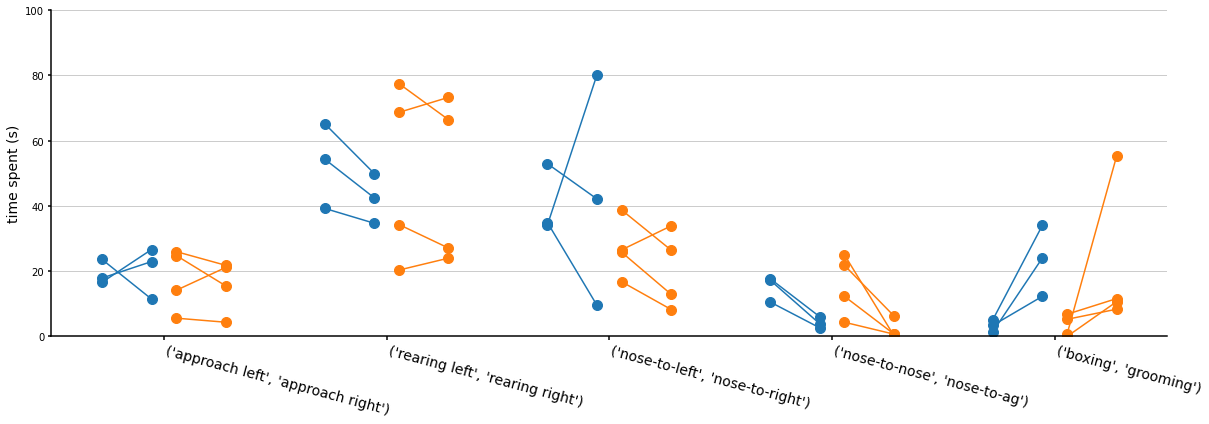

In [173]:
#phase_dict = {'habituate':(500,5500), 'preference':(6500,6500+11500), 'novelty':(18500,18500+11500)}
phase_dict = {'preference':(6500,6500+11500)}
behaviors = ( ('approach left', 'approach right'), ('rearing left', 'rearing right'), ('nose-to-left', 'nose-to-right'),
            ('nose-to-nose', 'nose-to-ag'), ('boxing', 'grooming')
            )
plot_jog = .5
phase_jog = plot_jog * 1.5
cond_jog = phase_jog * len(phase_dict)
beh_jog = cond_jog * 3

x_ticks = []

f,ax = plt.subplots(1,1,figsize=(20,6))

for beh_i, the_behaviors in enumerate(behaviors):
    #print(the_behaviors)
    for cond_i, the_cond in enumerate(stat_dict.keys()):
        #print(the_cond)
        for phase_i, the_phase in enumerate(phase_dict.keys()):
            x1 = (cond_i * cond_jog) + (phase_i * phase_jog) + (beh_i * beh_jog)
            #print(x1, x1+plot_jog)
            for the_subj in stat_dict[the_cond].keys():
                df_labels = stat_dict[the_cond][the_subj]['labels']
                ax.plot( (x1, x1 + plot_jog), 
                        (sum(df_labels.label.loc[df_labels.frame.isin(np.arange(phase_dict[the_phase][0],phase_dict[the_phase][1]))].values == the_behaviors[0])/20, 
                         sum(df_labels.label.loc[df_labels.frame.isin(np.arange(phase_dict[the_phase][0],phase_dict[the_phase][1]))].values == the_behaviors[1])/20), 
                         'o-', color = cdict[the_cond], markersize=10, alpha=1)
            #x_ticks.append( (x1, x1 + plot_jog) )
    
    x_ticks.append((cond_i * cond_jog) + (phase_i * phase_jog) + (beh_i * beh_jog) - (plot_jog/4) )


twoaxis(ax)
ax.set_xticks(np.asarray(x_ticks).flatten())
ax.set_xticklabels(behaviors, fontsize=14, rotation=345, horizontalalignment='left' )
ax.set_ylabel('time spent (s)', fontsize=14)
#ax.set_ylim(0,100)
ax.grid(color='gray', alpha=.5, axis='y')
plt.show()


***
### PVD (population vector distance)

In [26]:
the_cond = 'FMR1CTRL'
the_subj = 'OM051'

trace_mtx = stat_dict[the_cond][the_subj]['trace_mtx']
labels = stat_dict[the_cond][the_subj]['labels']

In [171]:
social_list = ['nose-to-nose']
object_list = ['nose-to-right']

In [172]:
social_frames = labels.frame.loc[(labels.label.isin(social_list))]
object_frames = labels.frame.loc[(labels.label.isin(object_list))]

In [173]:
social_trace_mtx = trace_mtx[social_frames,:]
object_trace_mtx = trace_mtx[object_frames,:]

In [212]:
#print(social_frames.values[518:])
#print(np.argwhere(np.diff(social_frames.values, prepend=0) > 1).flatten())
onsets_social = np.argwhere(np.diff(social_frames.values, prepend=0) > 1).flatten()
offsets_social = np.argwhere(np.diff(social_frames.values, append=social_frames.values[-1]+2) > 1).flatten()

onsets_object = np.argwhere(np.diff(object_frames.values, prepend=0) > 1).flatten()
offsets_object = np.argwhere(np.diff(object_frames.values, append=object_frames.values[-1]+2) > 1).flatten()

print('\n',onsets_social)
print(offsets_social)


 [  0   4  10  16  44  64  88 109 124 130 135 146 156 157 158 222 248 261
 271 294 306 338]
[  3   9  15  43  63  87 108 123 129 134 145 155 156 157 221 247 260 270
 293 305 337 344]


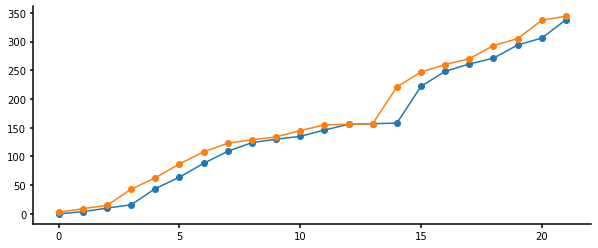

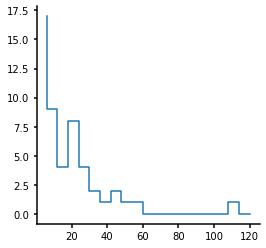

[  0.   6.  12.  18.  24.  30.  36.  42.  48.  54.  60.  66.  72.  78.
  84.  90.  96. 102. 108. 114. 120.]


In [213]:
f,ax = plt.subplots(1,1,figsize=(10,4))

#ax.plot(social_frames,'o')
ax.plot(onsets_social,'o-')
ax.plot(offsets_social,'o-')

twoaxis(ax)
plt.show()

h,hb = np.histogram(offsets_object - onsets_object, bins=20, range = (0,120), )
f,ax = plt.subplots(1,1,figsize=(4,4))
ax.step(hb[:-1]+(hb[1]-hb[0]), h)

twoaxis(ax)
plt.show()
print(hb)

In [214]:
print(np.mean(offsets_social - onsets_social))
print(np.mean(offsets_object - onsets_object))
print(onsets_social)
print(offsets_social)

14.681818181818182
17.24
[  0   4  10  16  44  64  88 109 124 130 135 146 156 157 158 222 248 261
 271 294 306 338]
[  3   9  15  43  63  87 108 123 129 134 145 155 156 157 221 247 260 270
 293 305 337 344]


In [177]:
print(social_trace_mtx.shape)
print(object_trace_mtx.shape)

(345, 109)
(912, 109)


In [166]:
bin_win = 100

In [178]:
the_cov = np.cov(np.concatenate((social_trace_mtx, object_trace_mtx), axis=0 ).transpose())

In [179]:
mahal = DistanceMetric.get_metric('mahalanobis', V = the_cov)

In [180]:
print(social_trace_mtx.shape)
print(object_trace_mtx.shape)
print(the_cov.shape)

(345, 109)
(912, 109)
(109, 109)


(109, 109)


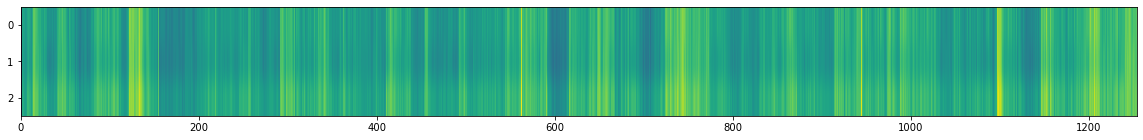

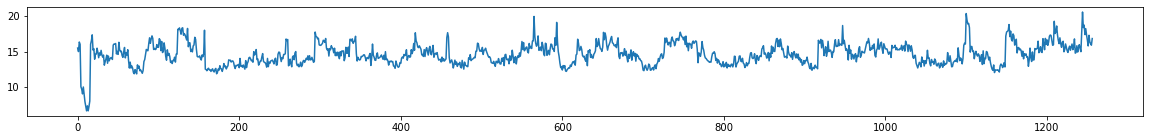

In [191]:
print(the_cov.shape)
f,ax = plt.subplots(1,1,figsize=(20,2))
ax.imshow(mahal.pairwise(social_trace_mtx[onsets_social[0]:offsets_social[0],:], 
                         np.concatenate((social_trace_mtx[offsets_social[0]:,:],object_trace_mtx), axis=0 ) ), aspect='auto')
#ax.imshow(mahal.pairwise(social_trace_mtx[:100,:], np.concatenate((social_trace_mtx[100:,:],object_trace_mtx), axis=0 ) ), aspect='equal')

plt.show()

f,ax = plt.subplots(1,1,figsize=(20,2))
ax.plot(np.median(mahal.pairwise(social_trace_mtx[onsets_social[2]:offsets_social[2],:], 
                              np.concatenate((social_trace_mtx[:,:],object_trace_mtx), axis=0 ) ), axis=0) )

plt.show()